<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="height:80px; display: inline"  alt="INSA"/></a> 

# Tutoriel en R: Détecter, Mesurer, Expliquer, Atténuer, la Discrimination Indirecte des Algorithmes d'Apprentissage Statistique

**Version courte**

**Résumé**
Analyse de données extraites d'un recensement aux USA de 1994 et disponibles sur le [dépôt de l'UCI](http://archive.ics.uci.edu/ml/). Elles permettent de mettre en relation le niveau de revenu (inférieur ou supérieur à 50k$), analogue à une "solvabilité" ou score de crédit, avec d'autres variables dont certaines sensibles car indiquant l'appartenance à un groupe protégé par la loi: genre, origine ethnique. Différents indicateurs de biais donc de sources de discrimination indirecte vis à vis d'un groupe, sont définis et illustrés sur ces données. Les principaux, consensuels dans la littérature, sont l'effet disproportionné ou *disparate / adverse impact* (DI) (*demographic equality*), le taux d'erreur conditionnel (*overall error equality*) et des mesures associées à l'asymétrie des matrices de confusion conditionnellement au groupe (*equalized odds*). Le tutoriel conduit a estimer ces différents biais lors de la prévision de la solvabilité par régression logistique (linéaire), arbre bianire puis un algorithme de forêts aléatoires. La doctrine "officielle" des enquêtes par *testing*, adaptée pour détecter une discrimination individuelle directe, est également évaluée sur les prévisions de ces deux algorithmes. Une procédure élémentaire d'atténuation du biais systémique par *post-processing* est enfin exécutée afin d'évaluer son impact sur la précision de prévision et les autres biais. L'objectif, pour répondre aux attentes du futur [règlement européen](https://digital-strategy.ec.europa.eu/en/library/proposal-regulation-european-approach-artificial-intelligence) sur l'IA (*AI Act*) est de rechercher, de façon explicite et documentée pour ce système d'IA, le moins mauvais compromis entre précision de prévision, explicabilité d'une décision et contrôle des biais discriminatoires.

**Remarques**
- Les principaux résultats de ce tutoriel ont servi d'illustration pour une intervention lors d'un séminaire commun CNIL & Défenseur des Droits (05/2020); ils sont explicités dans un article soumis ([Besse, 2020](https://hal.archives-ouvertes.fr/hal-02616963)) au regard des obligations listées dans les différents articles de l'*AI Act*.
- Ce tutoriel peut être exécuté en local après chargement ou clônage du dépôt ou encore dans le nuage *Google Colab* en cliquant sur le lien ci-dessous:

<a href="https://colab.research.google.com/github/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Introduction
###  Les données
Des données publiques disponibles sur le site [UCI repository](http://archive.ics.uci.edu/ml/) sont extraites de la base de données issue du recensement réalisé aux Etats Unis en 1994. Les deux fichiers *train* et *test* ont été réunis en un seul. Ces données sont largement utilisées et font référence comme outil de *benchmark* pour comparer les performances de méthodes d’apprentissage. L’objectif est de prévoir, avec plus ou moins de biais, la variable binaire "revenu annuel" supérieur ou inférieur à 50k$. Cette prévision n'impacte pas la personne mais comme la démarche et le contexte sont tout à fait similaires à ce que pourrait faire une banque pour évaluer un risque de crédit, cet exemple est très illustratif. Ce jeu de données est systématiquement utilisé (bac à sable) pour évaluer les propriétés des algorithmes d'apprentissage équitable ou loyal (*fair learning*) car, contrairement à beaucoup d'autres jeux de données utilisés pour cette fin (*e.g. german credit bank*), la vraie valeur de la variable cible est connue ainsi que l'origine ethnique des personnes concernées.

Dans les données initiales, 48.842 individus sont décrits par les 14 variables du tableau ci-dessous:


|Num|Libellé|Ensemble de valeurs|
|-|---------:|-------------------:|
|1|`Age`|real|
|2|`workClass`|Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked|
|3|`fnlwgt`|real|
|4|`education`|Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool|
|5|`educNum`|integer|
|6|`mariStat`|Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse|
|7|`occup`|Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces|
|8|`relationship`|Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
|9|`origEthn`|White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black|
|10|`sex`|Female, Male|
|11|`capitalGain`|real| 
|12|`capitalLoss`|real|
|13|`hoursWeek`|real|
|14|`nativCountry`|United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands|
|15|`income`|>50K, <=50K|


###  Préparation des données

Le traitement commence par une préparation détaillée des données:
- lecture et prise en charge des données en remarquant que la variable `fnlwgt` (Final sampling weight) a un [statut particulier](http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) pas très clair; elle est éliminée;
- suppression des observations présentant des données manquantes, erreurs ou incohérences,
- regroupement des modalités très dispersées, 
- suppression des variables redondantes. 

###  Estimation des biais

Parmi tous les critères de biais existant susceptibles de mettre en évidence une discrimination indirecte (Zliobaitė, 2015), trois ont été privilégiés (cf. Vermat et Rubin, 2018): 
1. discrimination indirecte par l'effet disproportionné: *disparate impact* ou *demographic equality*
2. comparaison des taux d'erreur conditionnels: *overall error equality*
3. comparaison des rapports de cote: *conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds*.

L'accent est mis dans ce premier tutoriel sur l'estimation de l'effet disproportionné (*disparate* ou *adverse impact*) vis-à-vis du genre. L'approximation de l'intervalle de confiance (Besse et al. 2021) est comparée avec une estimation *bootstrap* conduisant aux mêmes résultats. Les estimations sont calculées sur les données initiales de la base (biais de société ou systémique) puis sur les prévisions du seuil de revenu obtenues par deux algorithmes (régression logistique et forêts aléatoires) pour évaluer le risque de discrimination. L'impact de l'aténuation post processing de ce biais est évalué sur la précision et les autres types de biais.

**Remarques** 
- un [calepin plus détaillé](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb) mais plus long propose une comparaison des impacts des autres algorithmes d'apprentissage et donc de leur effet discriminatoire fonction du biais de société (genre et origine ethnique). Cela permet d'en mieux comprendre l'importance de la prise en compte des interactions entre les variables. 
- le site [aif360](https://aif360.mybluemix.net/) propose également un ensemble d'exemples et tutoriels. Il est plus riche: autres jeux de données, autres critères et surtout plus d'algorithmes de débiaisage, mais présente soit des démonstrations triviales, soit des exemples de méthodes très sophistiquées d'atténuation du biais. Ce tutoriel se veut plus pédagogique pour appréhender pas-à-pas les problèmes. 

##  Exploration des données
Lors de cette phase de travail, il y a deux points de vue radicalement différents. 
- Celui illustré par Friedler et al. (2019) consiste à entraîner un algorithme sur les données brutes sans exploration "humaine" préalable faisant appel à des compétences statistiques; par principe, tout est automatisé.
- Celui proposé dans ce tutoriel est le résultat d'une démarche nécessitant des compétences  statistiques élémentaires pour explorer les données, comprendre leur structure, détecter les problèmes potentiels: données manquantes, atypiques, biais, classes rares, distributions "anormales"...) afin d'y remédier au mieux, et d'illustrer l'intérêt de l'objectif poursuivi. 

Remarquons que ce deuxième point de vue de connaissance des données est plus respectueux des [lignes directrices des experts de la CE pour une IA digne de confiance](https://ec.europa.eu/futurium/en/ai-alliance-consultation) et anticipe la proposition de [règlement européen](https://digital-strategy.ec.europa.eu/en/library/proposal-regulation-european-approach-artificial-intelligence) (*AI Act) qui impose la rédaction d'une documentation (annexe IV) explicite sur les études préalables de qualité et pertinence des données.

###  Lecture et premières transformations
Deux possibilités pour charger les données issues du dépôt de l'UCI en fonction du mode d'exécution adopté; en local après avoir installé R ou à distance dans le nuage *Google Colab*. 
1. Dans le premier cas, les données sont chargées en même temps que le dépôt *Github*,
2. Dans le deuxième cas, <a href="https://colab.research.google.com/github/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
les données et le programme de transformation sont chargés et lus dans l'environnement de *Google Colab*; il est nécessaire d'exécuter la cellule ci-dessous.

In [1]:
# Exécuter cette cellule lors d'une exécution dans le nuage Google Colab
# sinon les données et fonctions sont déjà chargées en local
system("wget -P . https://github.com/wikistat/Fair-ML-4-Ethical-AI/raw/master/AdultCensus/adultTrainTest.csv")
system("wget -P . https://github.com/wikistat/Fair-ML-4-Ethical-AI/raw/master/AdultCensus/dataPrepAdultCensus.R")
system("mkdir ../Functions")
system("wget -P ../Functions https://raw.githubusercontent.com/wikistat/Fair-ML-4-Ethical-AI/master/Functions/dispImp.R")
system("wget -P ../Functions https://raw.githubusercontent.com/wikistat/Fair-ML-4-Ethical-AI/master/Functions/overErrEqual.R")
system("wget -P ../Functions https://raw.githubusercontent.com/wikistat/Fair-ML-4-Ethical-AI/master/Functions/oddsEqual.R")

Exécuter le programme de préparation des données, en consulter le code pour en étudier les principales fonctionnalités.

In [2]:
source("dataPrepAdultCensus.R")
dataBase = dataPrepAdultCensus()
summary(dataBase)

      age                workClass         fnlwgt              education    
 Min.   :18.00   Federal-Govt : 1390   Min.   :  13492   HS-grad    :14766  
 1st Qu.:28.00   Not-Working  :   21   1st Qu.: 117404   HS-Graduate: 9892  
 Median :37.00   Other-Govt   : 5023   Median : 178390   Bachelors  : 7569  
 Mean   :38.79   Private      :32856   Mean   : 189858   Dropout    : 5182  
 3rd Qu.:47.00   Self-Employed: 5425   3rd Qu.: 237998   Associates : 3466  
 Max.   :90.00                         Max.   :1490400   Masters    : 2512  
                                                         (Other)    : 1328  
    educNum               mariStat              occup      
 Min.   : 1.00   Married      :21079   Admin       : 5501  
 1st Qu.: 9.00   Never-Married:14100   Blue-Collar :14732  
 Median :10.00   Not-Married  : 8259   Other-occups: 2391  
 Mean   :10.16   Widowed      : 1277   Professional: 5992  
 3rd Qu.:13.00                         Sales       : 5272  
 Max.   :16.00          

###  Description statistique élémentaire
Mettre en évidence des difficultés présentes sur certaines variables ou couples de variables. 

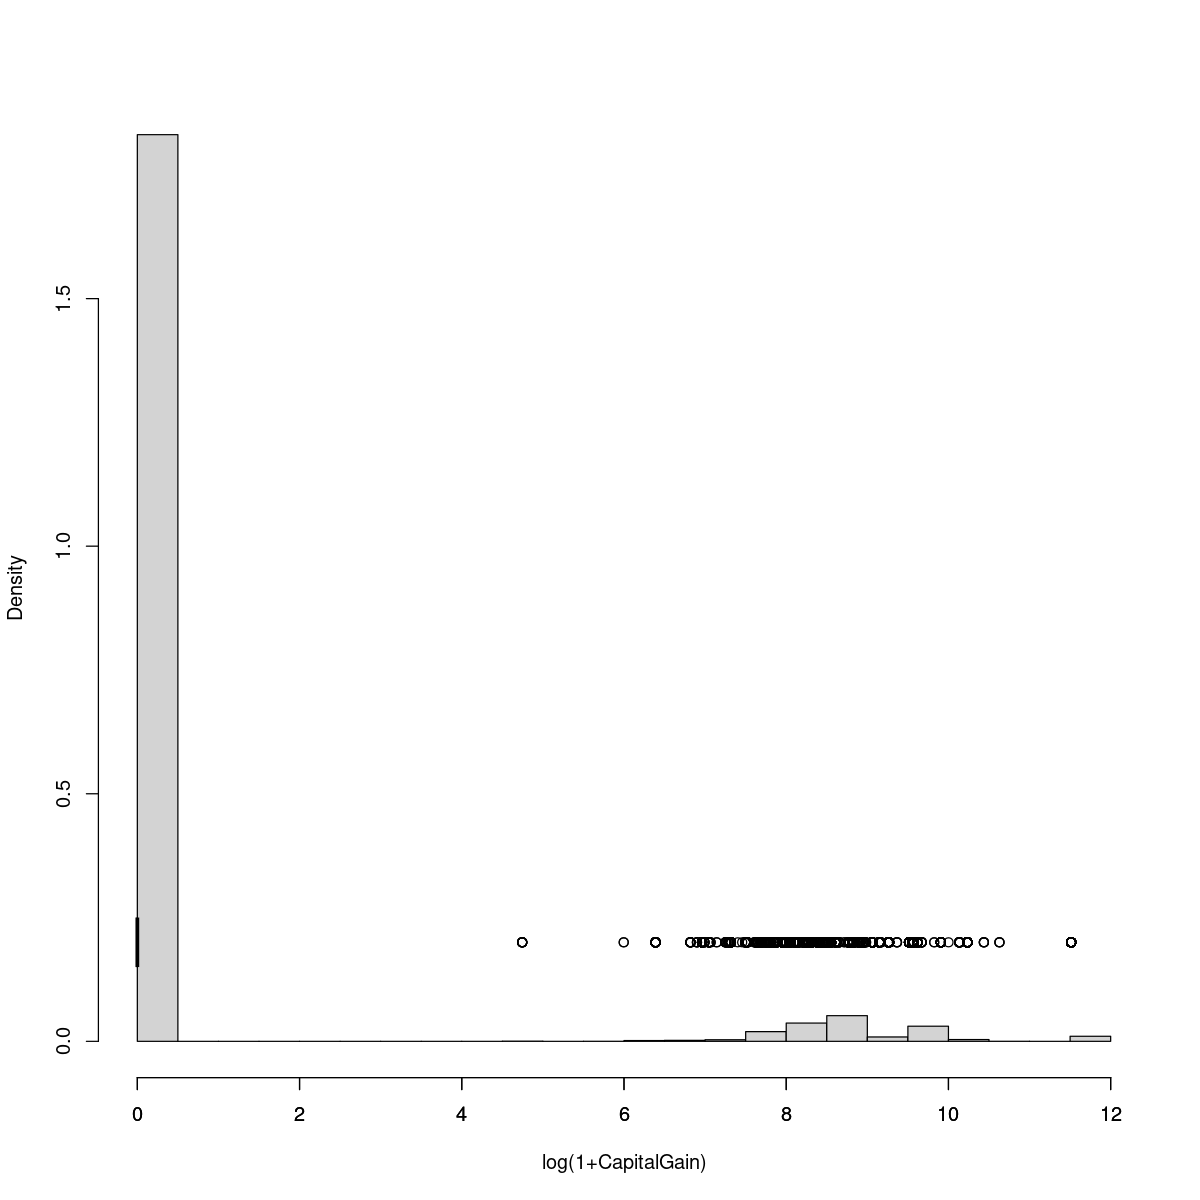

In [5]:
options(repr.plot.width=10, repr.plot.height=10)
hist(dataBase[,"LcapitalGain"],probability=T, main="",xlab="log(1+CapitalGain)")
boxplot(dataBase[,"LcapitalGain"], horizontal=TRUE,boxwex=.2,  outline=TRUE,  
        frame=F, col = "lightgrey", add = TRUE,at=0.2)

Distribution asymétrique d'où la nécessité de transformer certaines variables avant de contruire des modèles linéaires puis mise en évidence d'incohérences et de fortes redondances entre certaines variables.

In [6]:
table(dataBase$relationship,dataBase$sex)  

                
                 Female  Male
  Husband             1 18659
  Not-in-family    5404  6274
  Other-relative    599   721
  Own-child        2707  3477
  Unmarried        3649  1133
  Wife             2090     1

In [7]:
table(dataBase$education,dataBase$educNum)  

             
                  1     2     3     4     5     6     7     8     9    10    11
  Associates      0     0     0     0     0     0     0     0     0     0  1959
  Bachelors       0     0     0     0     0     0     0     0     0     0     0
  Doctorate       0     0     0     0     0     0     0     0     0     0     0
  Dropout        72   222   446   819   644  1073  1387   519     0     0     0
  HS-grad         0     0     0     0     0     0     0     0 14766     0     0
  HS-Graduate     0     0     0     0     0     0     0     0     0  9892     0
  Masters         0     0     0     0     0     0     0     0     0     0     0
  Prof-School     0     0     0     0     0     0     0     0     0     0     0
             
                 12    13    14    15    16
  Associates   1507     0     0     0     0
  Bachelors       0  7569     0     0     0
  Doctorate       0     0     0     0   544
  Dropout         0     0     0     0     0
  HS-grad         0     0     0 

In [8]:
table(dataBase$mariStat,dataBase$relationship)

               
                Husband Not-in-family Other-relative Own-child Unmarried  Wife
  Married         18660            19            184       125         0  2091
  Never-Married       0          6667            793      5423      1217     0
  Not-Married         0          4305            284       616      3054     0
  Widowed             0           687             59        20       511     0

In [9]:
table(dataBase$origEthn,dataBase$nativCountry)

             
              British-Commonwealth China Euro_1 Euro_2 Latin-America Other
  Amer-Indian                    0     1      1      2            12     0
  Asian                        125   185      4    101            13    61
  Black                         11     0     10      0           230     8
  Other                         12     0      2      1           125    11
  White                        333    10    313    229          1157   198
             
              SE-Asia South-America United-States
  Amer-Indian       1             1           410
  Asian           416             0           397
  Black             4             2          3929
  Other             0            31           166
  White            20           278         35905

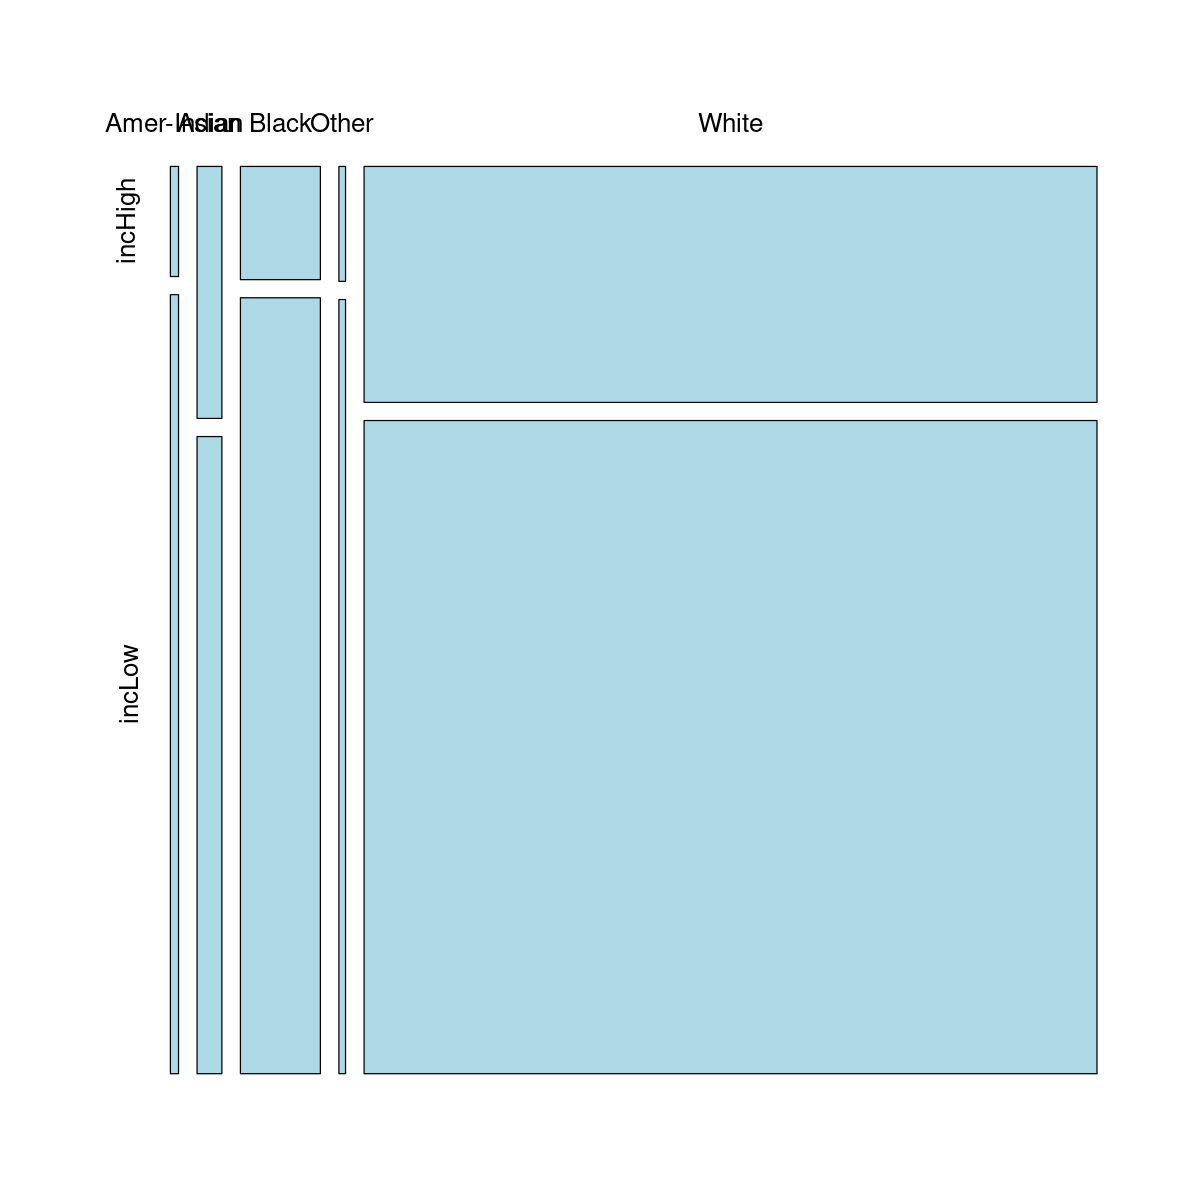

In [10]:
mosaicplot(table(dataBase[,"origEthn"],dataBase[,"income"]),main="", col="lightblue",cex=1.3)

Quelques modifications sont apportées dans la base; des variables sont supprimées afin de ne garder qu'une seule présence d'une information sensible: genre et origine ethnique.
- Suppression de la variable 3 `fnlwgt` qui n'a guère de signification pour cette analyse.
- Création d'une variable binaire `Child`: présence ou non d'enfants.
- Suppression de la variable 8 `relationship` redondante avec le genre et le statut marital,
- Suppression de la variable 14 `nativCountry` redondante avec l'origine ethnique.
- La variable 9 `originEthn` est simplifiée à 2 classes: CaucYes *vs.* CaucNo

**Attention** Pour la suite, il est important que les niveaux des facteurs soient ordonnés de façon cohérente pour la bonne interprétation des tables de contingence et de leurs effectifs. Par convention, les modalités pré-jugées socialement "dévavorables": revenu faible, femme, non caucasien (codées 0), précèdent les autres: revenu élevé, homme, caucasien (codées 1). Il faut donc soit réordonner les niveaux de la variable `income` ou renommer les modalités pour faire correspondre l'ordre alphabétique; ce deuxième choix est exécuté.

In [11]:
dataBase[,"child"]=as.factor(ifelse(dataBase$relationship=='Own-child',"ChildYes","ChildNo"))
dataBase[,"origEthn"]=as.factor(ifelse(dataBase$origEthn %in% c('Amer-Indian','Asian','Black','Other'),"CaucNo","CaucYes"))
dataBase[,"income"]=as.factor(ifelse(dataBase$income=='incLow',"incB","incH"))
datBas=dataBase[,-c(3,8,14)]
summary(datBas)

      age                workClass           education        educNum     
 Min.   :18.00   Federal-Govt : 1390   HS-grad    :14766   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   21   HS-Graduate: 9892   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 5023   Bachelors  : 7569   Median :10.00  
 Mean   :38.79   Private      :32856   Dropout    : 5182   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 5425   Associates : 3466   3rd Qu.:13.00  
 Max.   :90.00                         Masters    : 2512   Max.   :16.00  
                                       (Other)    : 1328                  
          mariStat              occup          origEthn         sex       
 Married      :21079   Admin       : 5501   CaucNo : 6272   Female:14450  
 Never-Married:14100   Blue-Collar :14732   CaucYes:38443   Male  :30265  
 Not-Married  : 8259   Other-occups: 2391                                 
 Widowed      : 1277   Professional: 5992                                 
                       Sa

Quelques *mosaicplots* basiques montrent le lien des variables sensibles avec la cible (seuil de revenu) et mettent clairement en évidence le biais de société.

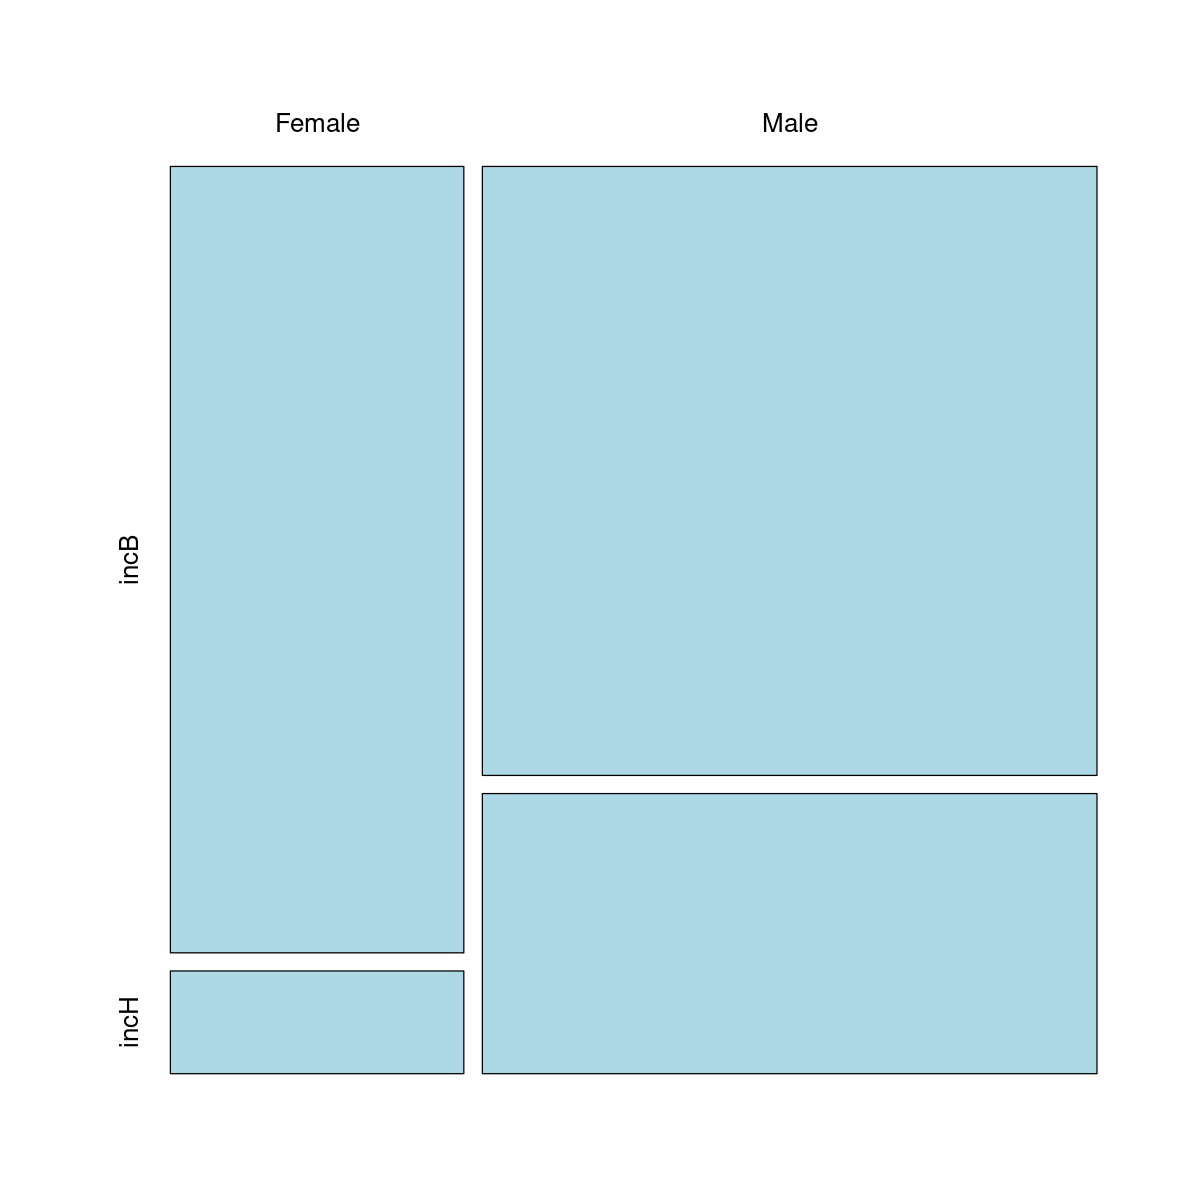

In [12]:
mosaicplot(table(datBas[,"sex"],datBas[,"income"]),main="", col="lightblue",cex=1.3)

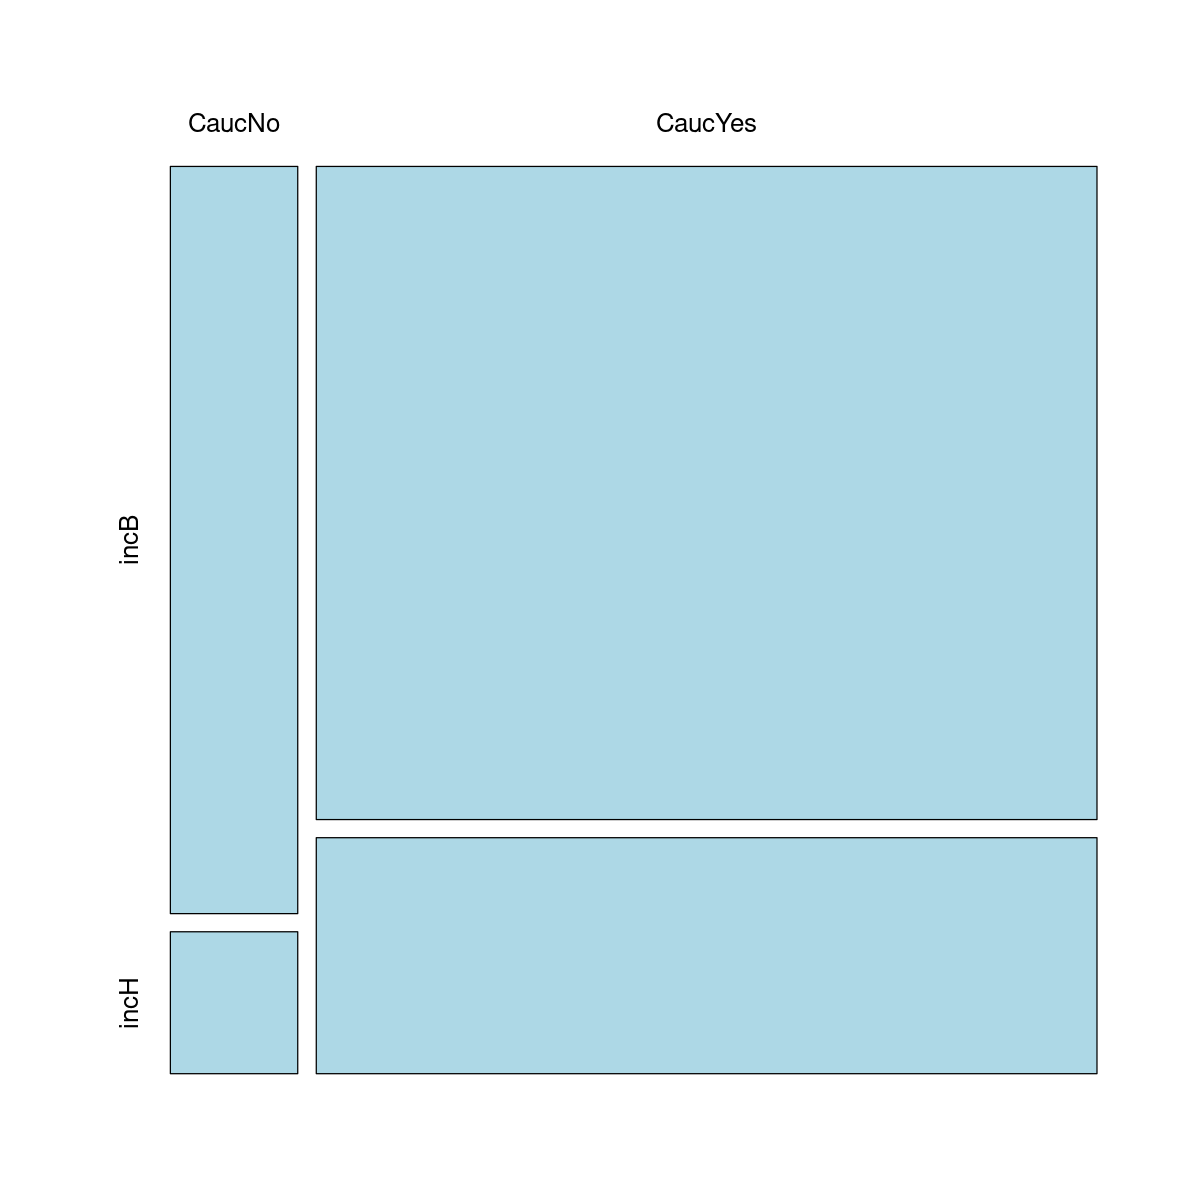

In [13]:
mosaicplot(table(datBas[,"origEthn"],datBas[,"income"]),main="",col="lightblue",cex=1.3)

**Q** Commentaires sur les biais présents dans la base, les déséquilibres des classes.


#  Préparation des échantillons
La base de données est divisée en deux échantillons d'apprentissage et de test. 

In [14]:
summary(datBas)

      age                workClass           education        educNum     
 Min.   :18.00   Federal-Govt : 1390   HS-grad    :14766   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   21   HS-Graduate: 9892   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 5023   Bachelors  : 7569   Median :10.00  
 Mean   :38.79   Private      :32856   Dropout    : 5182   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 5425   Associates : 3466   3rd Qu.:13.00  
 Max.   :90.00                         Masters    : 2512   Max.   :16.00  
                                       (Other)    : 1328                  
          mariStat              occup          origEthn         sex       
 Married      :21079   Admin       : 5501   CaucNo : 6272   Female:14450  
 Never-Married:14100   Blue-Collar :14732   CaucYes:38443   Male  :30265  
 Not-Married  : 8259   Other-occups: 2391                                 
 Widowed      : 1277   Professional: 5992                                 
                       Sa

Sélection des variables utilisées par la suite, celles qualitatives issues des quantitatives ne sont pas reprises.

In [15]:
datBas=datBas[,c("age","educNum","mariStat","occup","origEthn",
                 "sex","hoursWeek","income","LcapitalGain","LcapitalLoss","child")]
summary(datBas)

      age           educNum               mariStat              occup      
 Min.   :18.00   Min.   : 1.00   Married      :21079   Admin       : 5501  
 1st Qu.:28.00   1st Qu.: 9.00   Never-Married:14100   Blue-Collar :14732  
 Median :37.00   Median :10.00   Not-Married  : 8259   Other-occups: 2391  
 Mean   :38.79   Mean   :10.16   Widowed      : 1277   Professional: 5992  
 3rd Qu.:47.00   3rd Qu.:13.00                         Sales       : 5272  
 Max.   :90.00   Max.   :16.00                         Service     : 4846  
                                                       White-Collar: 5981  
    origEthn         sex          hoursWeek      income       LcapitalGain   
 CaucNo : 6272   Female:14450   Min.   : 1.00   incB:33511   Min.   : 0.000  
 CaucYes:38443   Male  :30265   1st Qu.:40.00   incH:11204   1st Qu.: 0.000  
                                Median :40.00                Median : 0.000  
                                Mean   :41.17                Mean   : 0.747  
  

Extraction des échantillons d'apprentissage, validation et test. Vous pouvez changer la valeur initiale `seed` du générateur de nombres aléatoires afin d'obtenir une autre répartition entre apprentissage, validation et test.

Comme l'échantillon initial est relativement volumineux, et conformément aux attendus du projet d'*AI Act*, un échantillon de validation est utilisé pour l'optimisation des hyper paramètres au lieu de procédures plus précises mais plus lourdes de validation croisée.

In [16]:
set.seed(11) # initialisation du générateur
# Extraction des échantillons
test.ratio=.2   # part des échantillons de test et validation
npop=nrow(datBas) # nombre de lignes dans les données
nvar=ncol(datBas) # nombre de colonnes
# taille des échantillons de validation et test
ntest=ceiling(npop*test.ratio) 
# indices de l'échantillon test
testi=sample(1:npop,ntest)
# indices restants de l'échantillon
resti=setdiff(1:npop,testi); nrest=length(resti)
# indices de l'échantillon de validation
vali=resti[sample(1:nrest,ntest)]
# indices de l'échantillon d'apprentissage
appri=setdiff(resti,vali)

In [17]:
# construction de l'échantillon d'apprentissage
datApp=datBas[appri,]
# construction de l'échantillon test 
daTest=datBas[testi,]
# construction de l'échantillon de validation
datVal=datBas[vali,]

Définition d'une fonction pour calculer le taux d'erreur usuel de la matrice de confusion. Avec l'ordonnancement des modalités, les bien classés sont les termes diagonaux de la matrice de confusion.

In [18]:
tauxErr=function(table){round((table[1,2]+table[2,1])/sum(table)*100,2)}

Les différents résultats sont stockés dans un tableau dans l'objectif d'un graphe comparatif de synthèse.

In [21]:
matRes=data.frame(matrix(0,8,4))
rownames(matRes)=c("dataBaseBias","linLogit","tree","linLogit_w_S","testingLogit","randomForest","TreeDiscrPos","RFdiscrPos")
colnames(matRes)=c("Lower","DI","Upper","Accuracy")

##  Prévision du seuil de revenu 
Une comparaison détaillée (cf. le [tutoriel](https://github.com/wikistat/Apprentissage/blob/master/Adult-Census/Apprent-Python-AdultCensus.ipynb)) de la plupart des modèles et algorithmes de prévision du seuil de revenu en fonction des différentes variables met en évidence des résultats de prévision un peu meilleurs obtenus par l'algorithme de *gradient boosting* (version xtrem). Néanmoins, on peut se limiter ici à un choix plus restreint de modèles et algorithmes pour comprendre l'impact sur la discrimination entre:
- la régression logistique (linéaire) interprétable,
- un arbre binaire de décision,
- les forêts aléatoires (non linéaires intégrant les interactions) mais sans capacité d'interprétation.

Un arbre binaire conduit à des qualités de prévision intermédiaires entre régression logistique et forêt aléatoire mais n'est pas facilement interprétable à cause du nombre jugé "optimal" mais élevé de feuilles.

###  Prévision par [régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

In [22]:
# estimation du modèle complet
log.lm=glm(income~.,data=datApp,family=binomial)

In [23]:
summary(log.lm)


Call:
glm(formula = income ~ ., family = binomial, data = datApp)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.910405   0.166637 -35.469  < 2e-16 ***
age                    0.024000   0.001660  14.461  < 2e-16 ***
educNum                0.283470   0.009560  29.652  < 2e-16 ***
mariStatNever-Married -2.376267   0.065494 -36.282  < 2e-16 ***
mariStatNot-Married   -2.171434   0.064887 -33.465  < 2e-16 ***
mariStatWidowed       -2.199881   0.153980 -14.287  < 2e-16 ***
occupBlue-Collar      -0.254208   0.073432  -3.462 0.000537 ***
occupOther-occups      0.417840   0.094381   4.427 9.55e-06 ***
occupProfessional      0.512599   0.079137   6.477 9.33e-11 ***
occupSales             0.214759   0.081410   2.638 0.008340 ** 
occupService          -0.874677   0.118583  -7.376 1.63e-13 ***
occupWhite-Collar      0.731801   0.076216   9.602  < 2e-16 ***
origEthnCaucYes        0.169796   0.060434   2.810 0.004960 ** 
sexMale               

**Q** Interprétation du rôle des variables sur le seuil de revenu.

In [24]:
# Prévision de l'échantillon test
pred.log=predict(log.lm,newdata=daTest,type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 6197  909
  TRUE   549 1288

In [30]:
err=tauxErr(confMat)
matRes[2,4]=(100-err)/100
print(paste("On fait ",err,"%", sep="% d'erreur avec le modèle de régression logistique"))

[1] "On fait % d'erreur avec le modèle de régression logistique16.3% d'erreur avec le modèle de régression logistique%"


**Remarque** Un modèle de régression logistique avec interactions, donc quadratique, ne conduit pas à une  prévision significativement meilleure mais nécessite une sélection de variables (*e.g. stepwise* ou `both`) longue à exécuter. Toujours par souci de concision, elle n'est pas reproduite; consulter le [calepin plus complet](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb).

###  Prévision par arbre binaire

In [31]:
summary(datApp)

      age           educNum               mariStat              occup     
 Min.   :18.00   Min.   : 1.00   Married      :12675   Admin       :3325  
 1st Qu.:28.00   1st Qu.: 9.00   Never-Married: 8482   Blue-Collar :8823  
 Median :37.00   Median :10.00   Not-Married  : 4944   Other-occups:1439  
 Mean   :38.78   Mean   :10.15   Widowed      :  728   Professional:3614  
 3rd Qu.:47.00   3rd Qu.:13.00                         Sales       :3179  
 Max.   :90.00   Max.   :16.00                         Service     :2874  
                                                       White-Collar:3575  
    origEthn         sex          hoursWeek      income       LcapitalGain    
 CaucNo : 3754   Female: 8691   Min.   : 1.00   incB:20088   Min.   : 0.0000  
 CaucYes:23075   Male  :18138   1st Qu.:40.00   incH: 6741   1st Qu.: 0.0000  
                                Median :40.00                Median : 0.0000  
                                Mean   :41.17                Mean   : 0.7523  
     

**Attention**: décommenter la commande d'installation ci-dessous lors d'une exécution dans le nuage ou si tout simplement cette librairie n'est pas installée.

In [32]:
library(rpart)
# Estimation du modèle complet
tree.mod=rpart(income~.,data=datApp,cp=0.0001)

Optimisation de la pénalité

In [38]:
xmat=xpred.rpart(tree.mod)
xerr=(xmat-as.integer(datApp[,"income"]))^2
CVerr=apply(xerr,2,sum)

In [39]:
as.numeric(attributes(which.min(CVerr))$names)

[1] 0.0008325895

In [40]:
tree.opt=rpart(income~.,data=datApp,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))

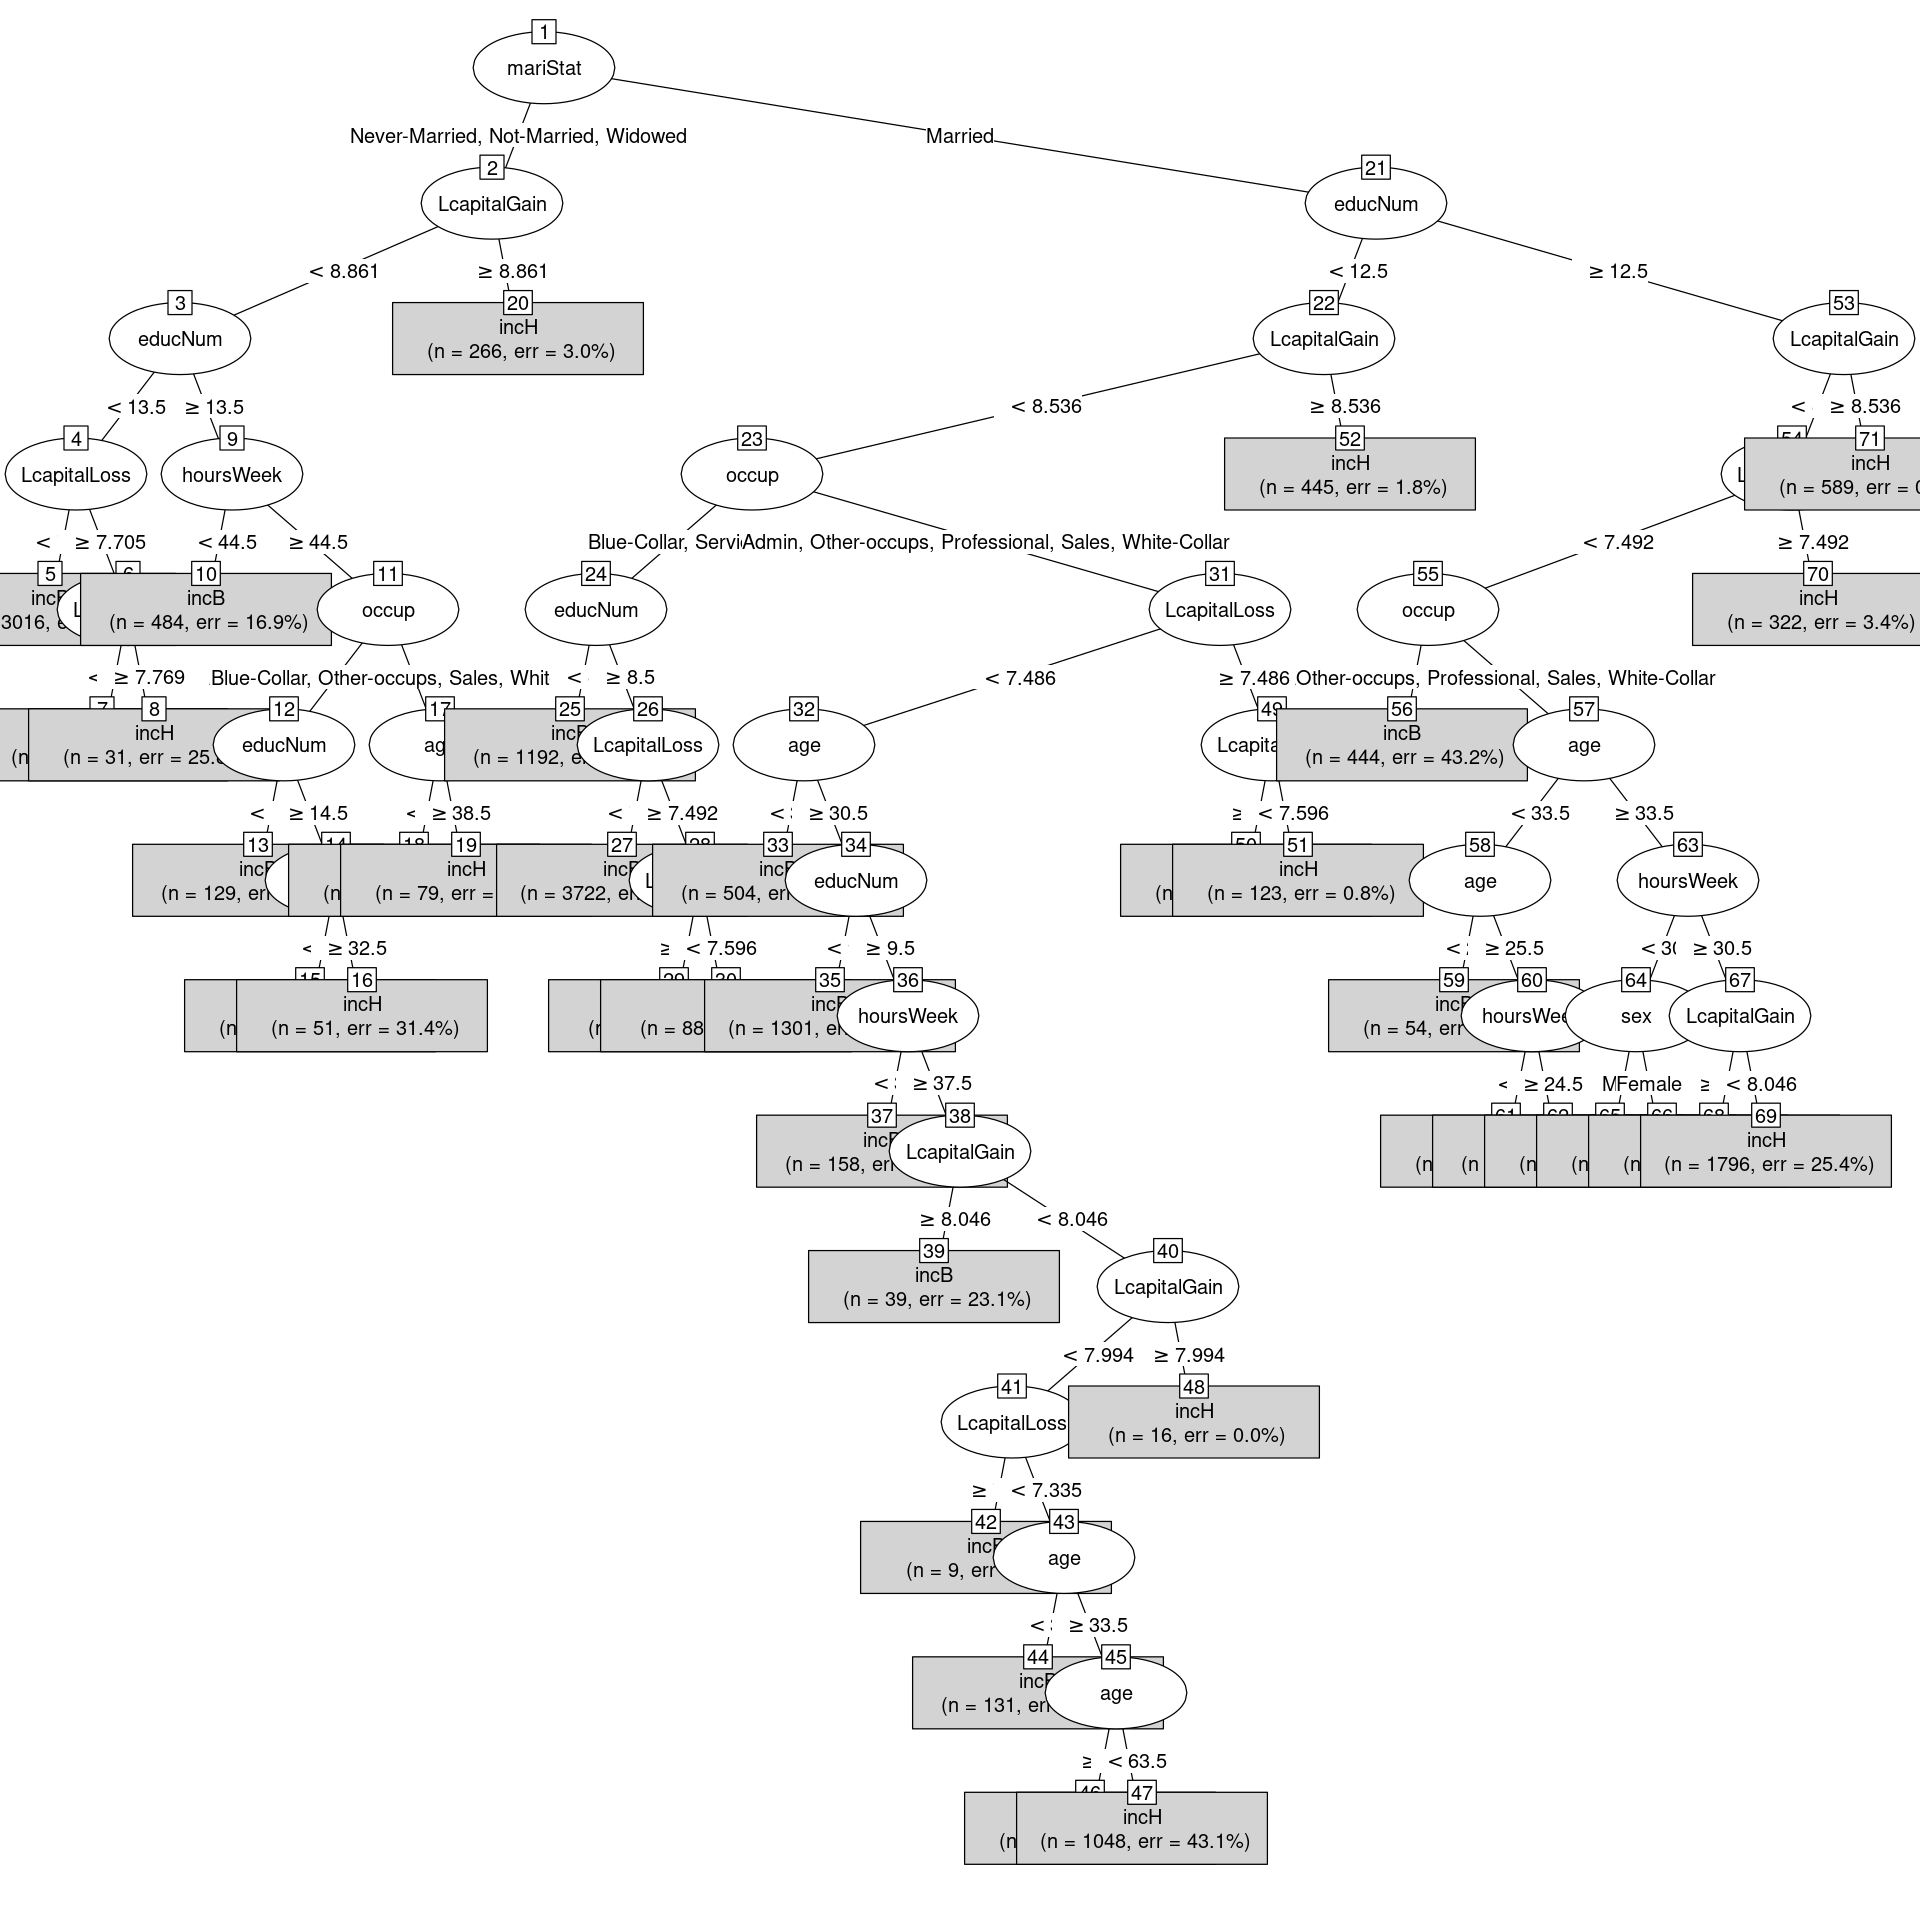

In [41]:
library(partykit)
options(repr.plot.width=16, repr.plot.height=16)
plot(as.party(tree.opt), type="simple")

**Q** Que dire de la clarté de l'interprétation de ce modèle?

C'est super, sauf vers le bas de l'arbre

**Q** Que dire de la présence de la variable genre?

Elle à l'air peu présente

Estimation de l'erreur sur l'échantillon test

In [46]:
pred.tree=predict(tree.opt,newdata=daTest,type="class")
confMat=table(pred.tree,daTest$income)
confMat
err=tauxErr(confMat)
matRes[3,4]=(100-err)/100
err

         
pred.tree incB incH
     incB 6341  860
     incH  405 1337

[1] 14.15

Un modèle plus simple est obtenu en augmentant la pénalisation mais avec pour conséquence de restreindre les performances. 

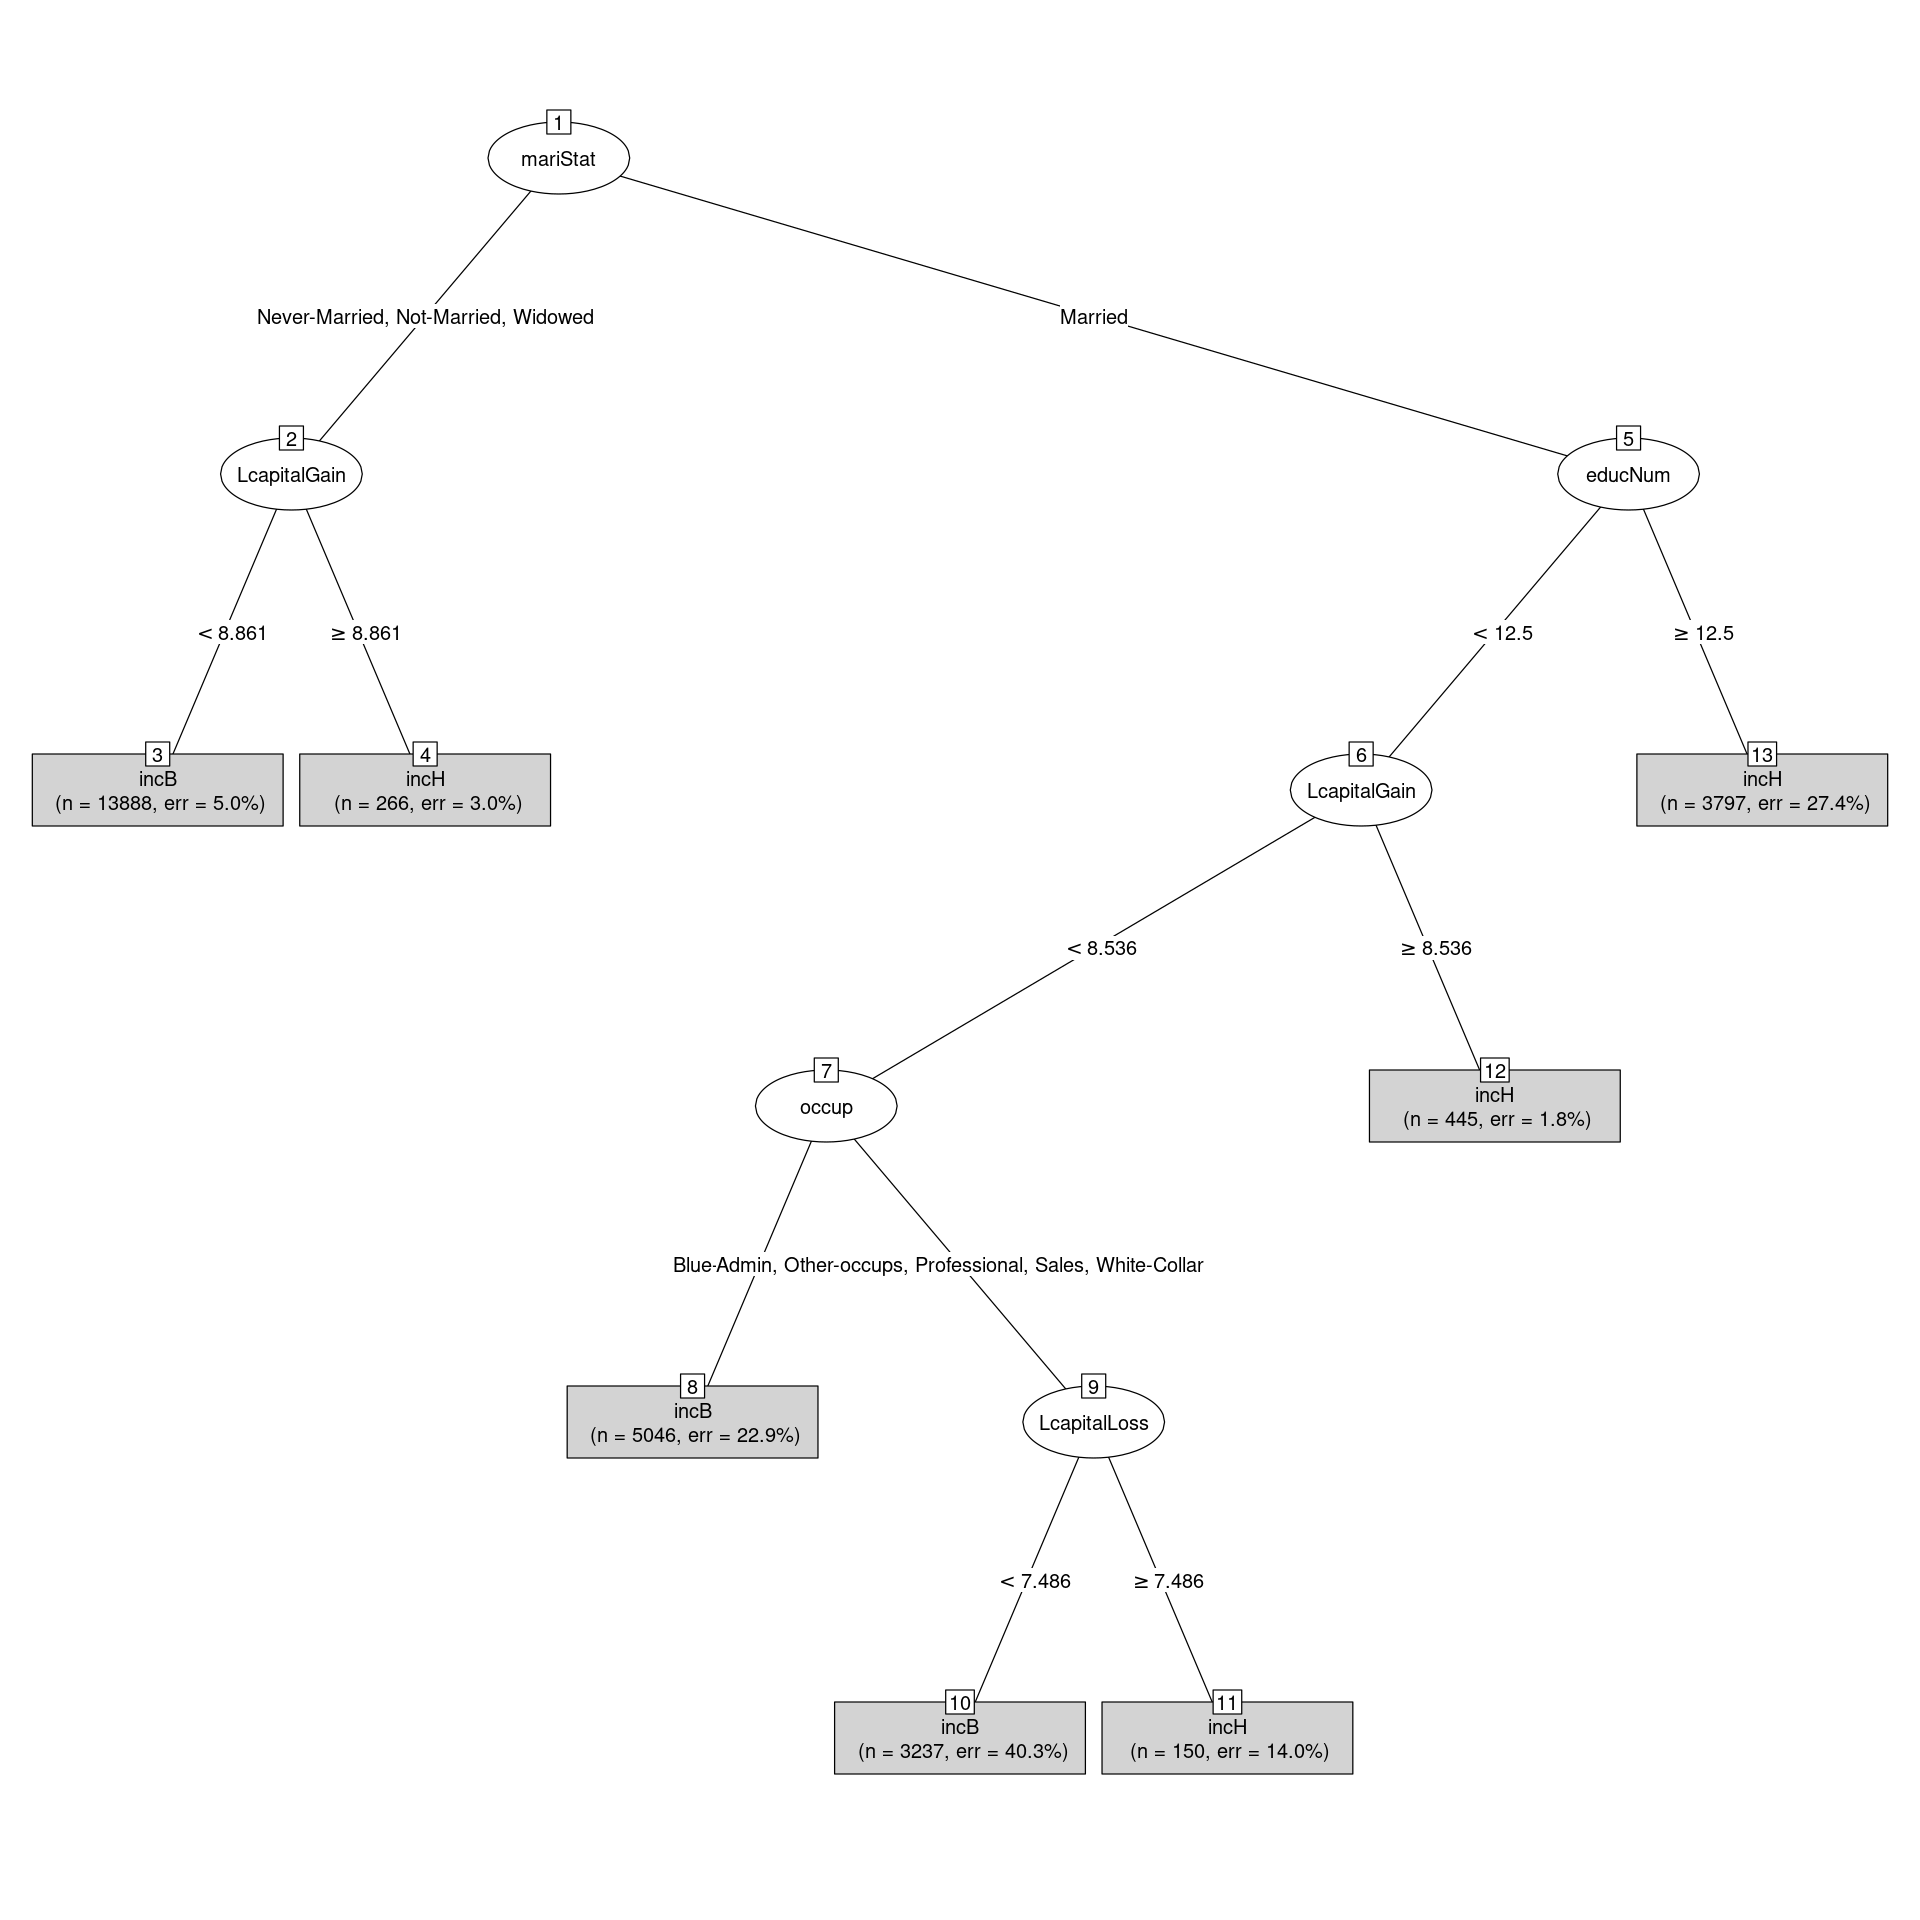

In [47]:
tree.int=rpart(income~.,data=datApp,control=rpart.control(cp=0.005))
plot(as.party(tree.int), type="simple")

In [45]:
pred.tree=predict(tree.int,newdata=daTest,type="class")
confMat=table(pred.tree,daTest$income)
confMat
tauxErr(confMat)

         
pred.tree incB incH
     incB 6366 1017
     incH  380 1180

[1] 15.62

###  Prévision par [forêts aléatoires](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

**Q** Quelles sont les options par défaut utilisées ci-dessous?

In [48]:
library(randomForest)
rf.mod=randomForest(income~.,data=datApp)
pred.rf=predict(rf.mod,newdata=daTest,type="response")
confMat=table(pred.rf,daTest$income)
confMat
err=tauxErr(confMat)
matRes[6,4]=(100-err)/100
err

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.



       
pred.rf incB incH
   incB 6320  825
   incH  426 1372

[1] 13.99

**Q** Comparer les résultats obtenus, précision et explicabilité.

Les calculs peuvent également être conduits en considérant l'origine ethnique comme variable sensible (consulter le [calepin plus complet](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb)) mais les résultats sont moins nets, moins "pédagogiques".

###  Modèle de régression logistique sans la variable genre
Une approche très naïve pour construire un apprentissage "loyal" consiste à supprimer la variable sensible. Le modèle de régression logistique est donc estimé sans cette variable afin d'évaluer par la suite l'impact sur le biais.

In [49]:
# estimation du modèle 
log_g.lm=glm(income~.,data=datApp[,-6],family=binomial)

In [50]:
# Prévision
pred_g.log=predict(log_g.lm,newdata=daTest[,-8],type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred_g.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 6201  907
  TRUE   545 1290

In [51]:
err=tauxErr(confMat)
matRes[4,4]=(100-err)/100
err

[1] 16.24

**Q** que dire de la qualité de prévision sans la variable genre?

##  Estimation de l'effet disproportionné
###  Définition
Les mesures de discrimination indirecte ou de groupe sont basées sur un critère d'effet disproportionné ou *disparate / adverse impact* (*DI*) apparu aux USA en 1971 (Barocas et Selbst, 2016) pour détecter des discriminations à l'embauche. Ce critère est défini par le rapport de deux probabilités : la probabilité de bénéficier d'une situation ou décision favorable (revenu élevé, crédit, emploi, logement...) pour une personne du groupe protégé par la loi (femme ou origine non caucasienne), sur la même probabilité pour une personne de l'autre groupe (homme ou origine caucasienne).

*Notations*: 

- $Y$ est la variable cible ou à expliquer, ici le revenu, $Y=1$ revenu élevé *vs* $Y=0$; 
- $g(X)=\hat{Y}$ le score élevé ou faible ou prévision du revenu, $g(X)=\hat{Y}=0$: prévision d'un revenu faible;
- $S$ est la variable sensible qui désigne le groupe en principe protégé par la loi contre une possible discrimination. Il s'agit ici du genre masculin ($S=1$) ou féminin ($S=0$). 

L'effet disproportionné mesure une situation de biais de société déjà présent dans la base de données. 
$$DI=\frac{P(Y=1|S=0)}{P(Y=1|S=1)}.$$
Il est estimé à partir des valeurs de la table de contingence croisant les variables $Y$ et $S$ par le rapport:
$$\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$$

Appliqué à la prévision $g(X)=\hat{Y}$ de la variable cible $Y$, il mesure le biais de cette prévision et donc le risque de discrimination opéré par la prévision.

###  Fonction `dispImp`
Une fonction R calcule le $DI$ et fournit de plus une estimation par intervalle de confiance [Besse et al, 2020](https://arxiv.org/pdf/2003.14263.pdf)
 décomposant la fonction de densité de la statistique de test par la *delta method*. Cette fonction a trois arguments:   
- la variable $S$ considérée comme sensible: un facteur à deux niveaux ordonnés "défavorable" puis "favorable";
- la variable cible $Y$ ou sa prévision $g(X)=\hat{Y}$: également un facteur à deux niveaux défavorable puis favorable;
- le risque de l'intervalle de confiance, par défaut 5%.

Cette fonction renvoie les trois estimations $DI$ et $IC_g$, $IC_d$ bornes de l'intervalle de confiance.

Morris S., Lobsenz R. (2000) avait déjà suggéré de calculer une estimation du *DI* par intervalle de confiance mais en faisant l'hypothèse de distributions gaussiennes; cette approximation n'est pas justifiée pour les effectifs d'une table de contingence.

In [52]:
source("../Functions/dispImp.R")

###  Effet disproportionné ou biais de la base d'apprentissage
La fonction `dispImp` nécessite que les niveaux des facteurs soient dans l'ordre lexicographique: niveaux "défavorable" puis "favorable".

Table de contingence croisant $Y$ (revenu) avec $S$ (genre).

In [53]:
tableDI=table(datBas$income,datBas$sex)
tableDI

      
       Female  Male
  incB  12781 20730
  incH   1669  9535

*Estimation ponctuelle* de $DI=\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$

In [57]:
round((tableDI[2,1]/(tableDI[1,1]+tableDI[2,1]))/(tableDI[2,2]/(tableDI[1,2]+tableDI[2,2])),3)

[1] 0.367

*Estimation par intervalle de confiance* approché par *delta method*. 

In [55]:
round(dispImp(datBas[,"sex"],datBas[,"income"]),3)

[1] 0.349 0.367 0.384

**Q** Commenter le biais ainsi mesuré, comparer avec le graphique obtenu (*mosaic plot*) lors de l'exploration.

Le biais est réel. Le DI est bien inférieur à 1; les données sont disproportionnées.

*[Estimation bootstrap](http://wikistat.fr/pdf/st-m-app-bootstrap.pdf) de l'intervalle de confiance*

L'estimation de l'intervalle de confiance est comparée avec le comportement du *DI* sur des échantillons *bootstrap* (Efron 1987).

In [61]:
B=1000 
set.seed(11)
n=nrow(datBas)
res=matrix(0,B,1)
for (i in 1:B)
    {
    boot=sample(n,n,replace=T)
    res[i,]=dispImp(datBas[boot,"sex"],datBas[boot,"income"])[2]
    }

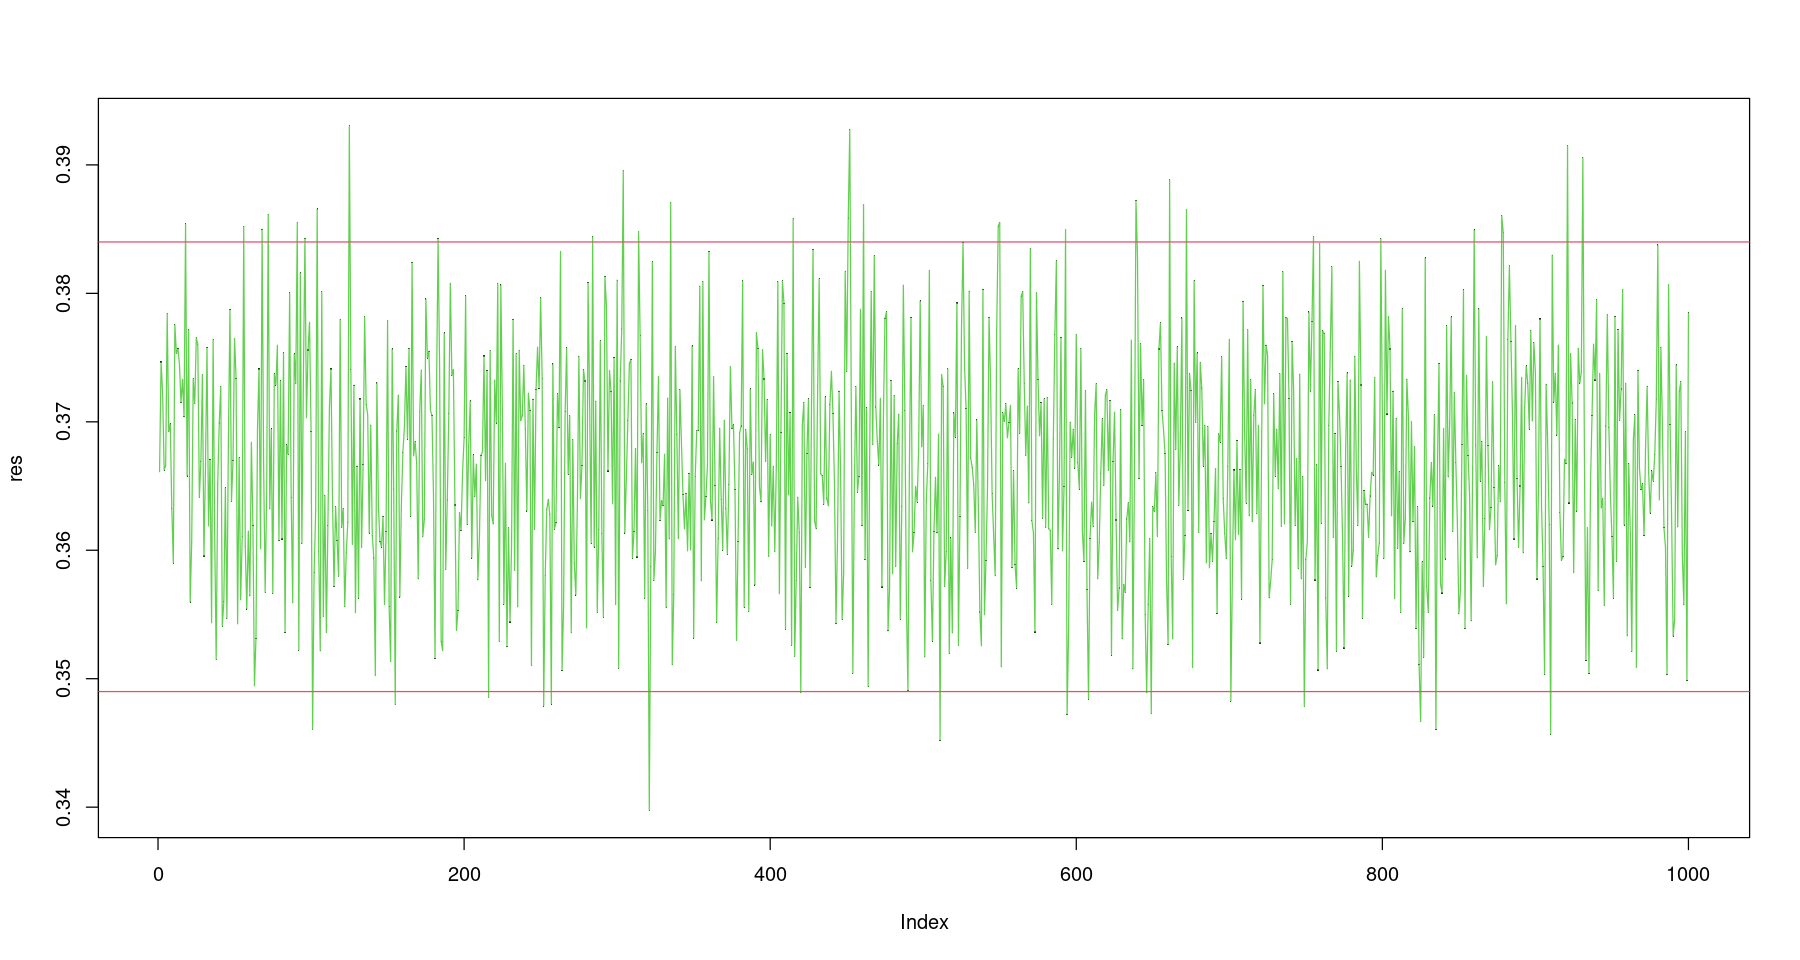

In [59]:
options(repr.plot.width=15, repr.plot.height=8)
DI_confInt_delta <- round(dispImp(datBas[,"sex"], datBas[,"income"]), 3)
plot(res,ylim=range(res),pch='.')
lines(res,col=3,pch='.')
abline(h=DI_confInt_delta[c(1, 3)], col=2) 

**Q** Que dire des estimations du *DI* sur les échantillons bootstrap par rapport aux bornes de l'intervalle de confiance ?

L'intervalle de confiance était bien ajusté

Une fonction de la librairie `boot` fournit une estimation bootstrap de l'intervalle de confiance.

In [80]:
library(boot)
fc <- function(d, i){ 
    d2 <- d[i,]
    return(statistic=dispImp(d2$sex,d2$income)[2])
}
set.seed(11)
bootDI <- boot(datBas,fc, R=1000)
bootDI


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = datBas, statistic = fc, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.3666135 9.319226e-05 0.009029887

In [81]:
boot.ci(boot.out = bootDI, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootDI, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 0.3494,  0.3848 )  
Calculations and Intervals on Original Scale

**Q** Comparer l'approximation par delta method et l'estimation bootstrap de l'intervalle de confiance.

**Q** Compte tenu des temps de calcul, que privilégier?

L'estimation de l'intervalle de confiance sur des échantillons bootstrap est à privilégier. Méthode delta

L'intervalle est finalement estimé sur l'échantillon test afin de comparer avec ces différentes prévisions.

In [64]:
ic=round(dispImp(daTest[,"sex"],daTest[,"income"]),3)
matRes[1,]=c(ic, 1)
ic

[1] 0.322 0.362 0.402

**Q** Que dire de la taille de l'intervalle de confiance?

###  Effet disproportionné des prévisions 
Le même ratio ou impact disproportionné calculé sur les prévisions $g(X)$ de $Y$ plutôt que sur $Y$ mesure explicitement l'effet de la prévision. Il revient à tester l'égalité des taux de prévision favorable entre les deux groupes. 

La valeur seuil de la probabilité pour prédire le niveau de revenu est fixée par défaut à $0.5$.

#### Régression logistique

In [70]:
Yhat=as.factor(pred.log>0.5)

In [66]:
ic=round(dispImp(daTest[,"sex"],Yhat),3)
matRes[2,1:3]=ic
ic

[1] 0.200 0.234 0.268

Le DI se réduit pour le modèle de régression logistique -> notre prédiction sous-estime les femmes

#### Arbre binaire

In [67]:
ic=round(dispImp(daTest[,"sex"],pred.tree),3)
matRes[3,1:3]=ic
ic

[1] 0.281 0.323 0.366

L'effet est un peu réduit par rapport à la regression logistique mais l'analyse est la même

#### *Random Forest*

In [68]:
ic=round(dispImp(daTest[,"sex"],pred.rf),3)
matRes[6,1:3]=ic
ic

[1] 0.297 0.340 0.383

De même...

**Q** Comparer les trois intervalles de confiance de l'estimation du *DI* dans le cas des données initiales, de la prévision par régression logistique et de celle par forêt aléatoire. Conclusion?

Random forest s'approche le + de l'intervalle trouvé en réalité.

#### Effet disproportionné des prévisions sans la variable sensible genre

In [72]:
Yhat_g=as.factor(pred_g.log>0.5)
ic=round(dispImp(daTest[,"sex"],Yhat_g),3)
matRes[4,1:3]=ic
ic

[1] 0.215 0.250 0.286

La variable genre est tellement correlée aux autres que meme si le modele ne la voit pas il discrimine quand meme le sexe feminin

**Q** Que devient le DI avec une prévision n'utilisant pas la variable sensible?

Le [calepin long](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb) vérifie ces résultats en considérant (validation croisée *Monte Carlo*) 20 réplications de la séparation des échantillons d'apprentissage et de test sur lesquels sont entraînés trois algorithmes: régression logistique, arbre de décision, *random forest*, avant d'évaluer le DI observé sur la prévision de l'échantillon test. 

Comme attendu, la précision dépend fortement de l'algorithme choisi. Par ailleurs, on constate ici que, meilleure est la précision et moins le biais est renforcé par rapport à celui `DIbase` des données d'entraînement. Mais, pour un algorithme donné, le *DI* n'est pas corrélé à la précision sur un échantillon d'apprentissage.

**Q** Conclusion partielle sur l'impact de chaque algorithme, dont il faudrait aussi prendre en compte les capacités d'interprétabilité, surtout vis-à-vis de la loi américaine.

**Attention** comme le rappelle Friedler et al. (2019) les résultats et conclusions peuvent changer d'un jeu de données à un autre. C'est déjà bien connu en ce qui concerne la précision de la prévision, il est nécessaire de l'intégrer dans la gestion du biais. Les résultats présentés dans ce tutoriel, sont sur certains points, différents de ceux de Friedler et al. (2019). La principale raison en est sans doute la différence de stratégie adoptée pour le traitement préalable des données. Par principe, Friedler et al. (2019) analysent sans aucune perspective statistique élémentaire les données brutes et donc sans aucun traitement préalable. Il y a peut être aussi, à vérifier, des différences d'implémentation entre les versions R et Python des algorithmes.

###  Effet disproportionné *vs. Testing*
#### Enquête commanditée par la DARES
Le *testing* est, à l'origine, une méthode usuelle permettant de détecter une discrimination *directe* opérée par un humain. Elle est "adaptée" (Riach et Rich 2002) et déployée par la ([DARES](http://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/etudes-et-syntheses/dares-analyses-dares-indicateurs-dares-resultats/testing)) du Ministère du Travail  (cf. [article Le Monde 2020](https://www.lemonde.fr/societe/article/2020/01/08/une-etude-montre-des-discriminations-a-l-embauche-significatives-en-fonction-de-l-origine_6025227_3224.html)) à la détection par enquête d'une discrimination indirecte envers un groupe. Il consiste à évaluer la variabilité d'une décision lorsque seule la modalité de la variable sensible est modifiée. 

Les calculs ci-dessous permettent de reproduire les résultats globaux de la dernière enquête de la DARES.

In [93]:
origine.i=matrix(0,10000,1);reponse.i=matrix(0,10000,1)
origine.i[4536:8910]=1;origine.i[9376:10000]=1
reponse.i[8911:10000]=1
origine=factor(origine.i,labels=c("Maghreb","France"))
reponse=factor(reponse.i,labels=c("Negative","Positive"))
table <- table(reponse, origine)
table

          origine
reponse    Maghreb France
  Negative    4535   4375
  Positive     465    625

In [94]:
paste(100*465/5000,"%",sep="");paste(100*625/5000,"%",sep=""); 465/625

[1] "9.3%"

[1] "12.5%"

[1] 0.744

Les ratios sont bien ceux de l'enquête. Il y a de très nombreuses façons de les comparer afin de conclure ou non à une discirmination jugée significative. Que donne l'évaluation de l'effet disproportionné?

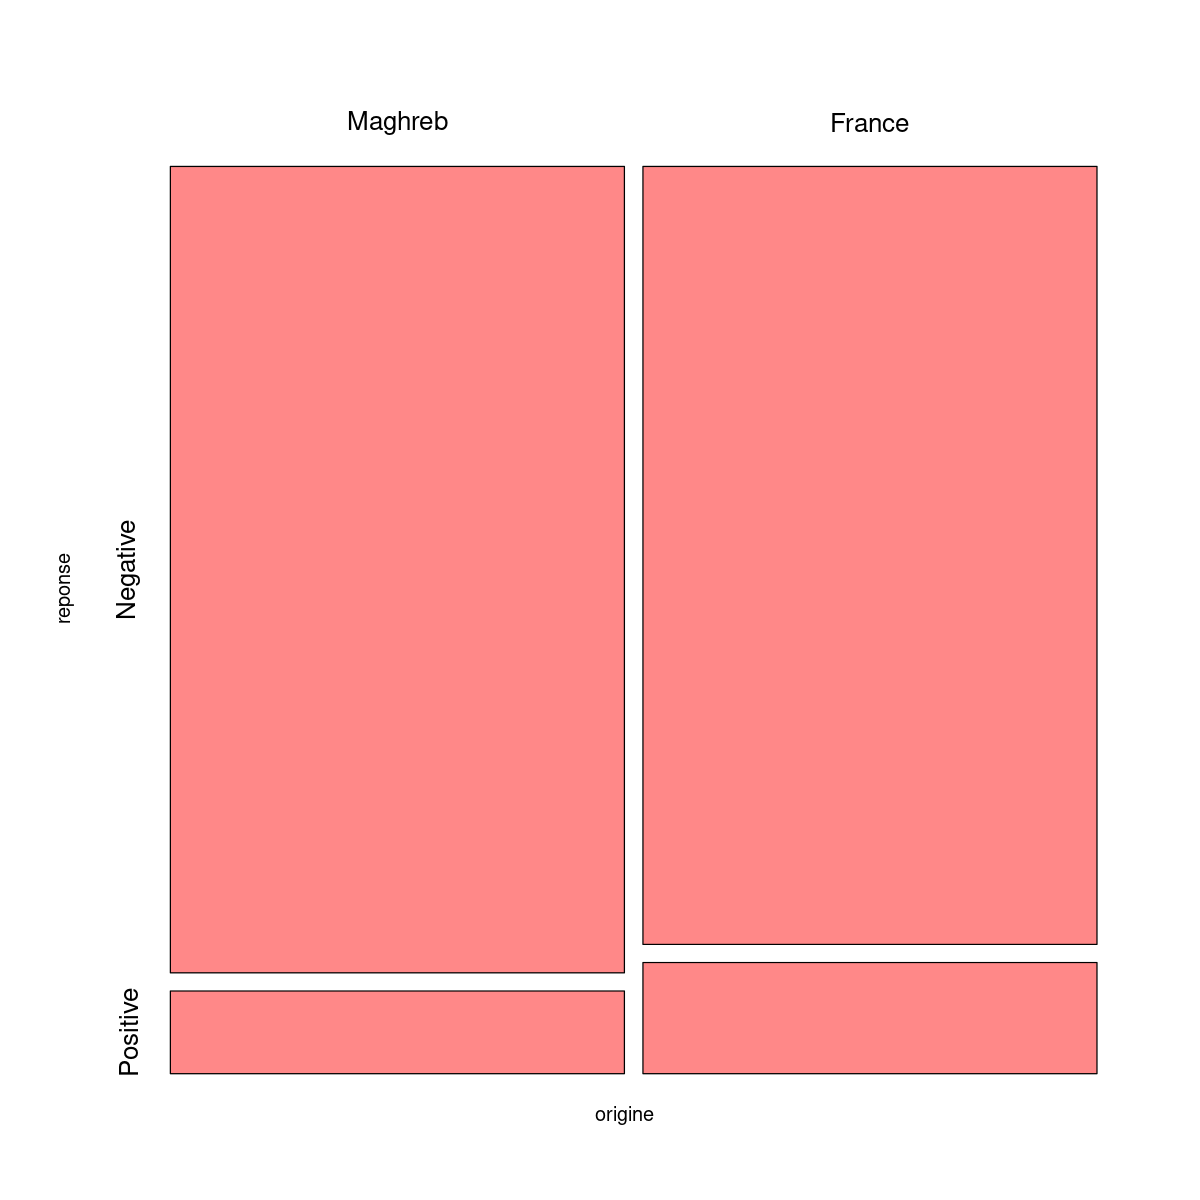

In [109]:
options(repr.plot.width=10, repr.plot.height=10)
mosaicplot(table(origine,reponse),main="",col="#ff8888",cex=1.3)

In [95]:
round(dispImp(origine,reponse),3)

[1] 0.660 0.744 0.828

**Q** Cette enquête par *testing* met-elle en évidence une discrimination statistiquement significative au regard du règlement américain (règle des 4/5ème)?

La majorité de l'intervalle de confiance se situe sous le seuil des 4/5, ou 0.8, donc il y a probablement discrimination. Cependant, comme 0.8 appartient à l'intervalle de confiance, cela serait acceptable selon la législation américaine. Testons d'autres méthodes, afin de mettre en lumière une potentielle discrimination.

**Q** Que dire de la précision de l'évaluation du *DI* avec 10 000 CVs envoyés? Serait-il possible de conclure pour une entreprise donnée?

#### *Testing* d'un algorithme d'apprentissage
Que se passe-t-il si le *testing* est appliqué à une décision automatique pilotée par un algorithme d'apprentissage? 

Les prévisions de revenu sont calculées pour les mêmes personnes de l'échantillon test en prenant en compte le genre initial puis le genre opposé. Dans ce cas, une femme pour laquelle la prévision de revenu ou solvabilité change lorsque la variable genre passe de `Female` à `Male` serait en droit d'intenter une action en justice pour discrimination directe. 

In [110]:
daTest2=daTest
# Changement de genre
daTest2$sex=as.factor(ifelse(daTest$sex=="Male","Female","Male"))
# Prévision du "nouvel" échantillon test
pred2.log=predict(log.lm,daTest2,type="response")
Yhat2=as.factor(pred2.log>0.5)

In [111]:
table(Yhat,Yhat2)

       Yhat2
Yhat    FALSE TRUE
  FALSE  7090   16
  TRUE    135 1702

16 = 16 femmes qui en déclarant qu'elles étaient un homme ont pu avoir un crédit 

In [112]:
# répartition par genre
table(Yhat,Yhat2,daTest$sex)

, ,  = Female

       Yhat2
Yhat    FALSE TRUE
  FALSE  2671   16
  TRUE      0  183

, ,  = Male

       Yhat2
Yhat    FALSE TRUE
  FALSE  4419    0
  TRUE    135 1519


**Q** Compléter: Il y a $16 + 135$ personnes dont la prévision de revenu change lorsqu'elles changent de genre. Et le changement est dans le sens attendu.
- $16$ femmes passent d'une prévision de revenu faible à une prévision de revenu élevé
- $135$ hommes prennnent le chemin inverse  lorsqu'ils deviennent des femmes; ces hommes bénificiaient donc d'une discrimination positive!

Quels résultats fourniraient une enquête par testing consistant à envoyer deux fois les "dossiers" à l'algorithme, une fois pour chaque genre? Il faut donc considérer deux fois plus de personnes en concaténant les deux prévisions. Ceci conduit à la table de contingence ci-dessous. 

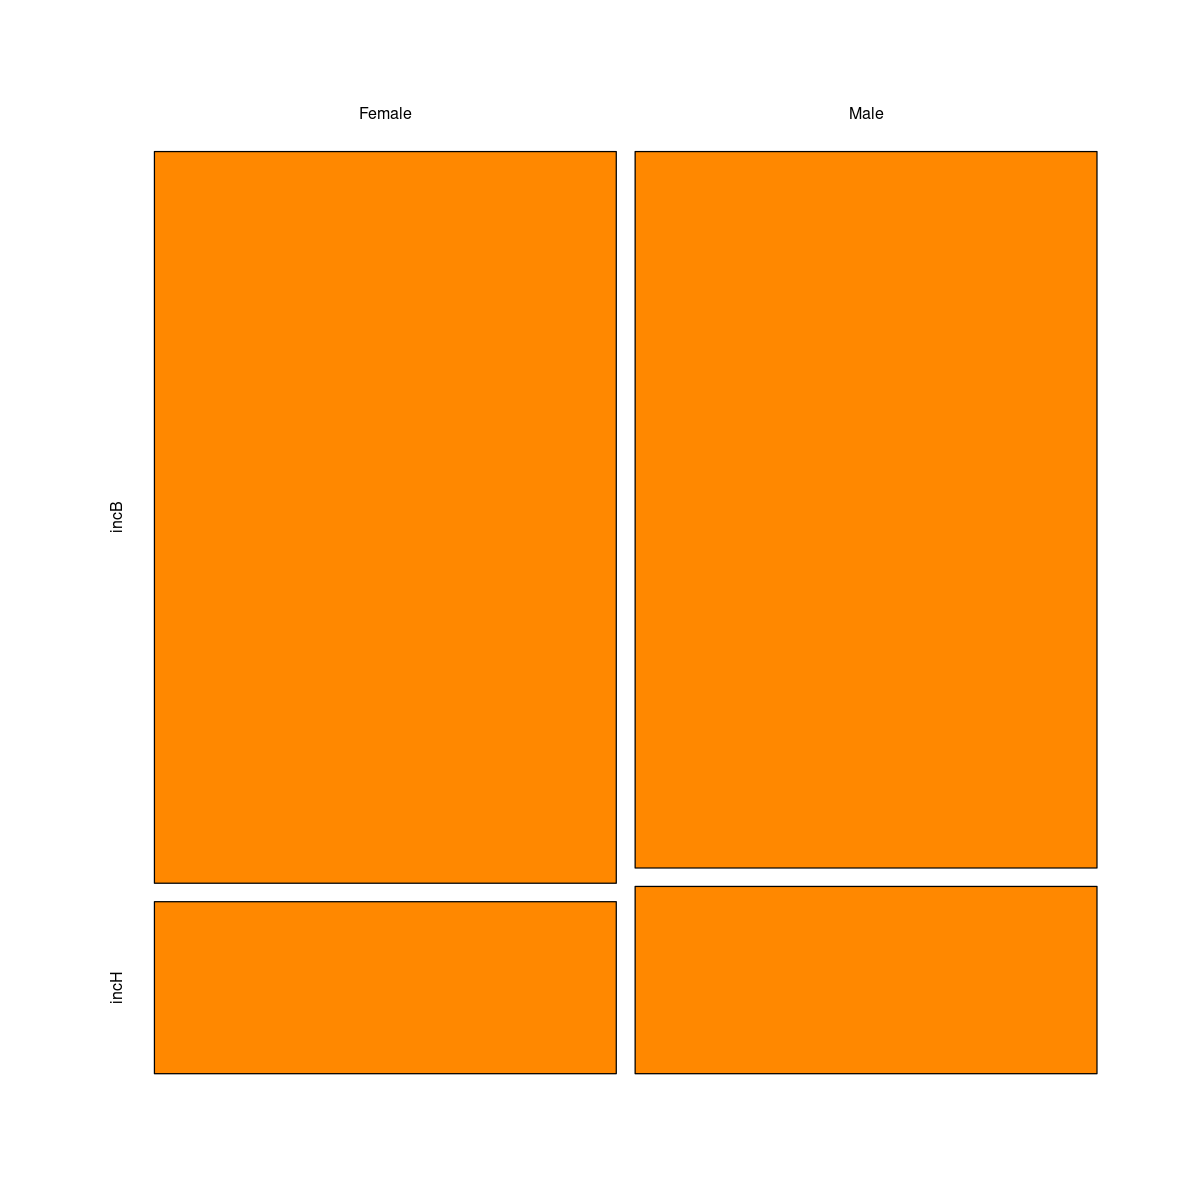

In [115]:
# fonction de concaténation de deux vecteurs de type factor
c.factor <- function(..., recursive=TRUE) unlist(list(...), recursive=recursive) 
Yhat=factor(Yhat,labels=c("incB","incH")); Yhat2=factor(Yhat2,labels=c("incB","incH"))
mosaicplot(table(c.factor(daTest$sex,daTest2[,"sex"]),c.factor(Yhat,Yhat2)),main="",col="#ff8800",cex=.8)

In [116]:
ic=round(dispImp(c.factor(daTest$sex,daTest2[,"sex"]),c.factor(Yhat,Yhat2)),3)
matRes[5,1:3]=ic
ic

[1] 0.864 0.919 0.973

**Q** Conclusion: le testing est-il adapté à détecter une discrimination algorithmique? <br>non car il y a une discrimination mais pourtant le DI signifie qu'il n'y en a pas

**Q** A quoi est principalement due cette incapacité? Penser au rôle de la variable genre dans les prévisions. <br>Comme vu précédemment, la variable genre en elle même est fortement corrélée avec d'autres présentes dans le dataset, d'ou l'impact relativement faible que l'on obsrve. Il s'agit aussi de faux individus, peu réalistes. 

#### *Testing* et prévision "déloyale" 
Une façon simple pour une entreprise de se prémunir contre une opération de *testing* consiste à fixer comme probablité prédite le maximum des deux probablités obtenues en échangeant les modalités de la variable sensible. De façon générale, choisir la situation la plus favorable pour la personne quelque soit le genre observé. La discrimination individuelle repérable par *testing* est neutralisée et l'influence sur le taux d'erreur quasi négligeable. 

In [119]:
fairPredictGenre=pmax(pred.log, pred2.log) 
confMat=table(fairPredictGenre>0.5,daTest$income)
confMat;err=tauxErr(confMat)
matRes[5,4]=(100-err)/100
err

       
        incB incH
  FALSE 6188  902
  TRUE   558 1295

[1] 16.33

In [118]:
round(dispImp(daTest$sex,as.factor(pred.log>0.5)),3)
round(dispImp(daTest$sex,as.factor(fairPredictGenre>0.5)),3)

[1] 0.200 0.234 0.268

[1] 0.219 0.255 0.290

**Attention** Cette procédure masque de façon **intentionnelle** la discrimination directe détectable par testing tout en favorisant une discrimination indirecte, elle est clairement **condamnable au sens du code pénal**. Soyez prudent dans vos futures pratiques professionnelles!

C'est pas bien !! (Vraiment pas bien)

##  Expliquer, atténuer la discrimination ?
De façon notable, le modèle de régression logistique reproduit le biais social et le renforce en introduisant donc de la discrimination; c'est moins net pour l'algorithme des forêts aléatoires,  Est-il possible d'expliquer ce comportement ou plus précisément d'utiliser le bon modèle ou bon algorithme qui l'évite? Le [calepin long](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb) compare différents algorithmes selon diverses situations notamment en attribuant sans succès plus de poids aux femmes afin de compenser leur sous-représentation. 

La littérature propose une avalanche de méthodes pour débiaiser une décision algorithmique. Trois approches sont développées:
- *Pre-processing* en débiaisant les données d'apprentissage;
- *Processing* en pénalisant la fonction objectif avec une contrainte d'équité mais l'optimisation n'est plus convexe;
- *Post-processing* en dé-biaisant les décisions.

Friedler et al. (2019) et le site [AIF360](https://aif360.mybluemix.net/) proposent une comparaison numérique systématique de quelques unes de ces approches sur plusieurs jeux de données publiques donc celui de ce tutoriel. 

Une version rudimentaire mais efficace de post-processing consiste à estimer deux modèles ou entraîner deux algorithmes, l'un pour les femmes et l'autre pour les hommes puis d'adapter le seuil de décision afin de réduire l'effet disproportioné tout en contrôlant le taux d'erreur. Cette procédure est testée dans les cas  d'un arbre binaire et des forêts aléatoires. C'est une façon d'introduire une dose de discrimination positive afin d'infléchir vers plus d'équité sociale.

Une première partie consiste à estimer séparément les modèles avant d'introduire de la discrimination positive dans une deuxième partie.

**Remarque** Il n'est sans doute pas nécessaire d'estimer deux modèles de forêts aléatoires selon le genre. Le seul post-processing des seuils de décision devrait suffire. 

### Séparation des deux échantillons
Les échantillons sont séparés en deux parties.

In [177]:
datAppF=subset(datApp, sex == 'Female') 
datAppM=subset(datApp, sex == 'Male')
datValF=subset(datVal, sex == 'Female') 
datValM=subset(datVal, sex == 'Male')
daTestF=subset(daTest, sex == 'Female')
daTestM=subset(daTest, sex == 'Male')
summary(datAppM)

      age           educNum               mariStat              occup     
 Min.   :18.00   Min.   : 1.00   Married      :11345   Admin       :1099  
 1st Qu.:30.00   1st Qu.: 9.00   Never-Married: 4680   Blue-Collar :7886  
 Median :38.00   Median :10.00   Not-Married  : 1988   Other-occups:1033  
 Mean   :39.57   Mean   :10.13   Widowed      :  125   Professional:2290  
 3rd Qu.:48.00   3rd Qu.:13.00                         Sales       :2075  
 Max.   :90.00   Max.   :16.00                         Service     :1206  
                                                       White-Collar:2549  
    origEthn         sex          hoursWeek      income       LcapitalGain   
 CaucNo : 2113   Female:    0   Min.   : 1.00   incB:12409   Min.   : 0.000  
 CaucYes:16025   Male  :18138   1st Qu.:40.00   incH: 5729   1st Qu.: 0.000  
                                Median :40.00                Median : 0.000  
                                Mean   :43.05                Mean   : 0.879  
          

###  Régression logistique
Estimation des deux modèles.

In [178]:
reg.log=glm(income~.,data=datApp,family=binomial)
# estimation des deux modèles
reg.logF=glm(income~.,data=datAppF[,-6],family=binomial)
reg.logM=glm(income~.,data=datAppM[,-6],family=binomial)
# comparaison des paramètres
summary(reg.logF);summary(reg.logM)


Call:
glm(formula = income ~ ., family = binomial, data = datAppF[, 
    -6])

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -6.835009   0.379287 -18.021  < 2e-16 ***
age                    0.029832   0.004172   7.150 8.66e-13 ***
educNum                0.346088   0.025512  13.566  < 2e-16 ***
mariStatNever-Married -3.216805   0.125970 -25.536  < 2e-16 ***
mariStatNot-Married   -3.229895   0.121236 -26.641  < 2e-16 ***
mariStatWidowed       -3.173383   0.220384 -14.399  < 2e-16 ***
occupBlue-Collar      -0.417374   0.210696  -1.981  0.04760 *  
occupOther-occups      0.596344   0.209743   2.843  0.00447 ** 
occupProfessional      0.597619   0.143771   4.157 3.23e-05 ***
occupSales             0.236130   0.173118   1.364  0.17257    
occupService          -0.431031   0.185819  -2.320  0.02036 *  
occupWhite-Collar      0.979756   0.140865   6.955 3.52e-12 ***
origEthnCaucYes        0.285183   0.128414   2.221  0.02636 *  
hoursWeek 


Call:
glm(formula = income ~ ., family = binomial, data = datAppM[, 
    -6])

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.600953   0.193508 -28.944  < 2e-16 ***
age                    0.024373   0.001826  13.351  < 2e-16 ***
educNum                0.271453   0.010316  26.313  < 2e-16 ***
mariStatNever-Married -2.133984   0.078496 -27.186  < 2e-16 ***
mariStatNot-Married   -1.690265   0.078616 -21.500  < 2e-16 ***
mariStatWidowed       -1.275574   0.263274  -4.845 1.27e-06 ***
occupBlue-Collar      -0.304215   0.090317  -3.368 0.000756 ***
occupOther-occups      0.352416   0.112458   3.134 0.001726 ** 
occupProfessional      0.450032   0.101031   4.454 8.41e-06 ***
occupSales             0.177322   0.099730   1.778 0.075401 .  
occupService          -1.201666   0.159845  -7.518 5.58e-14 ***
occupWhite-Collar      0.635823   0.096354   6.599 4.14e-11 ***
origEthnCaucYes        0.137546   0.069515   1.979 0.047856 *  
hoursWeek 

**Q** La comparaison des paramètres des deux modèles apporte-t-elle des informations?

In [179]:
# prévision des modèles
yHat=predict(reg.log,newdata=daTest,type="response")
yHatF=predict(reg.logF,newdata=daTestF,type="response")
yHatM=predict(reg.logM,newdata=daTestM,type="response")
# compilation des prévisions
yHatFM=c(yHatF,yHatM)

In [210]:
daTestFM=rbind(daTestF,daTestM)
datAppFM=rbind(datAppF, datAppM)
dim(daTestFM)

[1] 8943   11

In [181]:
# erreurs cumulées
table(yHatFM>0.5,daTestFM$income)

       
        incB incH
  FALSE 6184  897
  TRUE   562 1300

In [182]:
table(yHat>0.5,daTest$income)

       
        incB incH
  FALSE 6197  909
  TRUE   549 1288

In [183]:
tauxErr(table(yHatFM>0.5,daTestFM$income))

[1] 16.31

In [186]:
tauxErr(table(yHat>0.5,daTest$income))

[1] 16.3

**Q** Que devient l'erreur de prévision une fois que les deux modèles sont associés avec le même seuil de décision?

In [193]:
# biais cumulés vs. biais 
round(dispImp(daTestFM[,"sex"],as.factor(yHatFM>0.5)),3);
round(dispImp(daTest[,"sex"],as.factor(yHat>0.5)),3)

[1] 0.267 0.307 0.347

[1] 0.200 0.234 0.268

prédictions

In [212]:
# Rappel: Biais de la base de test
round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)
round(dispImp(datAppFM[,"sex"],datAppFM[,"income"]),3)

[1] 0.322 0.362 0.402

[1] 0.346 0.369 0.391

**Q** Que devient le bais?

Il s'améliore un peu, sans pour autant atteindre le niveau du set de test.

###  Arbre binaire 
L'objectif est de rechercher un moins mauvais compromis entre précision, interprétatbilité et biais. On se limite à des arbres simples par l'introduction d'une pénalisation sous optimale qui impose un nombre limité de feuilles. Ce paramètre mériterait d'être "optimisé" mais la fonction objectif n'est pas claire, dépendant d'impératifs politiques et commerciaux dans la recherche du compromis. Nous retenons le choix opéré précédemment sur l'échantillon de validation.

In [208]:
library(rpart)
# Modèle initial
tree.init=tree.int=rpart(income~.,data=datApp,control=rpart.control(cp=0.005))
# estimation des deux modèles
tree.F=rpart(income~.,data=datAppF[,-6],control=rpart.control(cp=0.005))
tree.M=rpart(income~.,data=datAppM[,-6],control=rpart.control(cp=0.005))
# comparaison des arbres

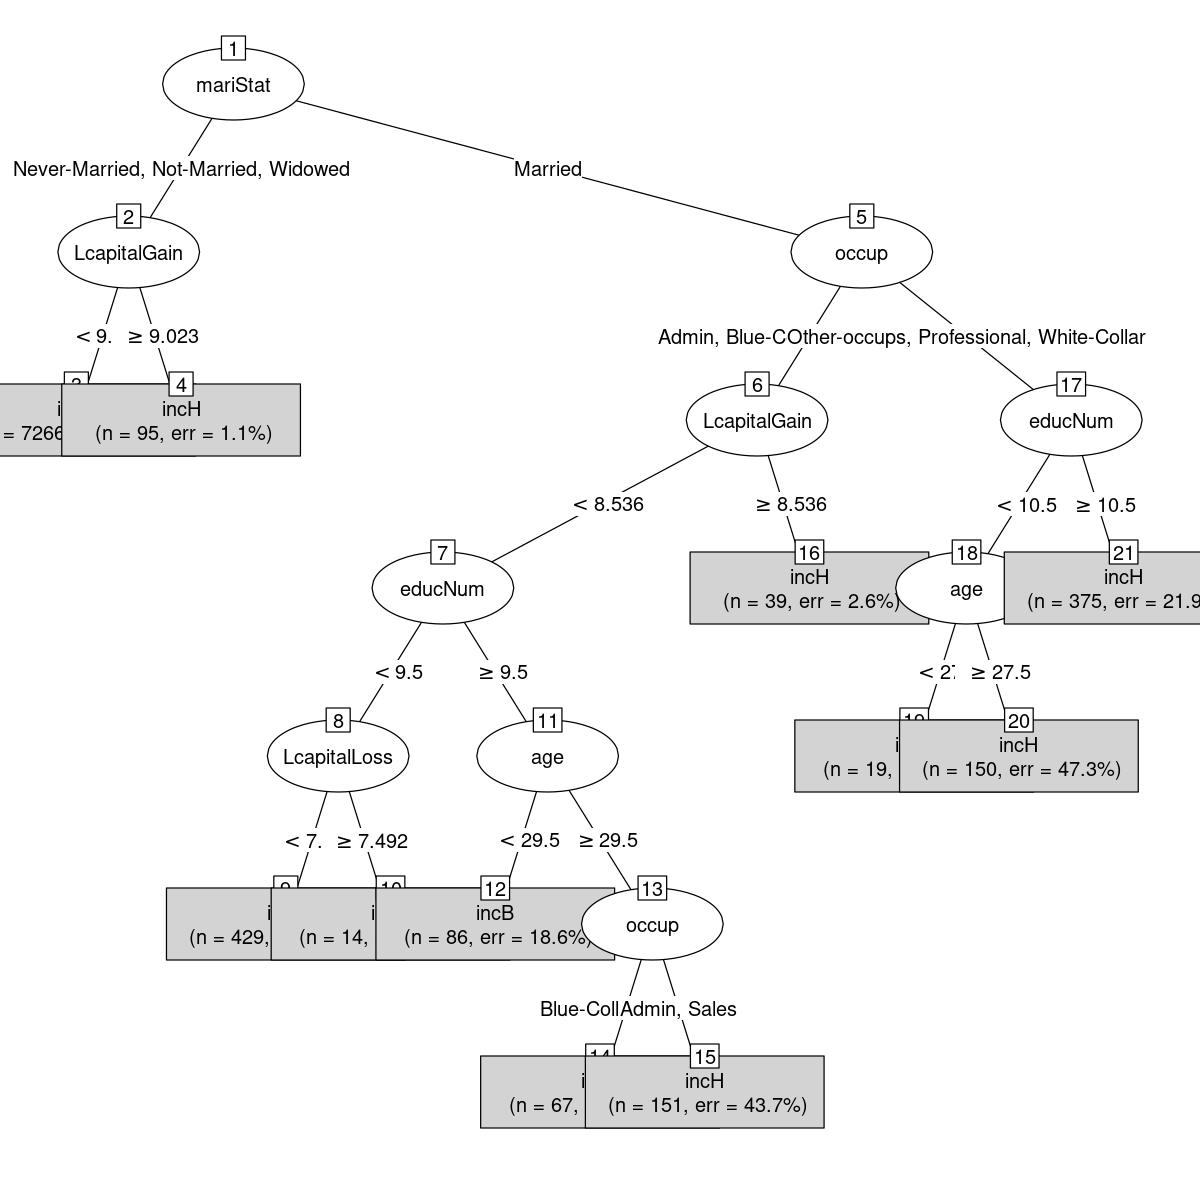

In [213]:
options(repr.plot.width=10, repr.plot.height=10)
plot(as.party(tree.F), type="simple")

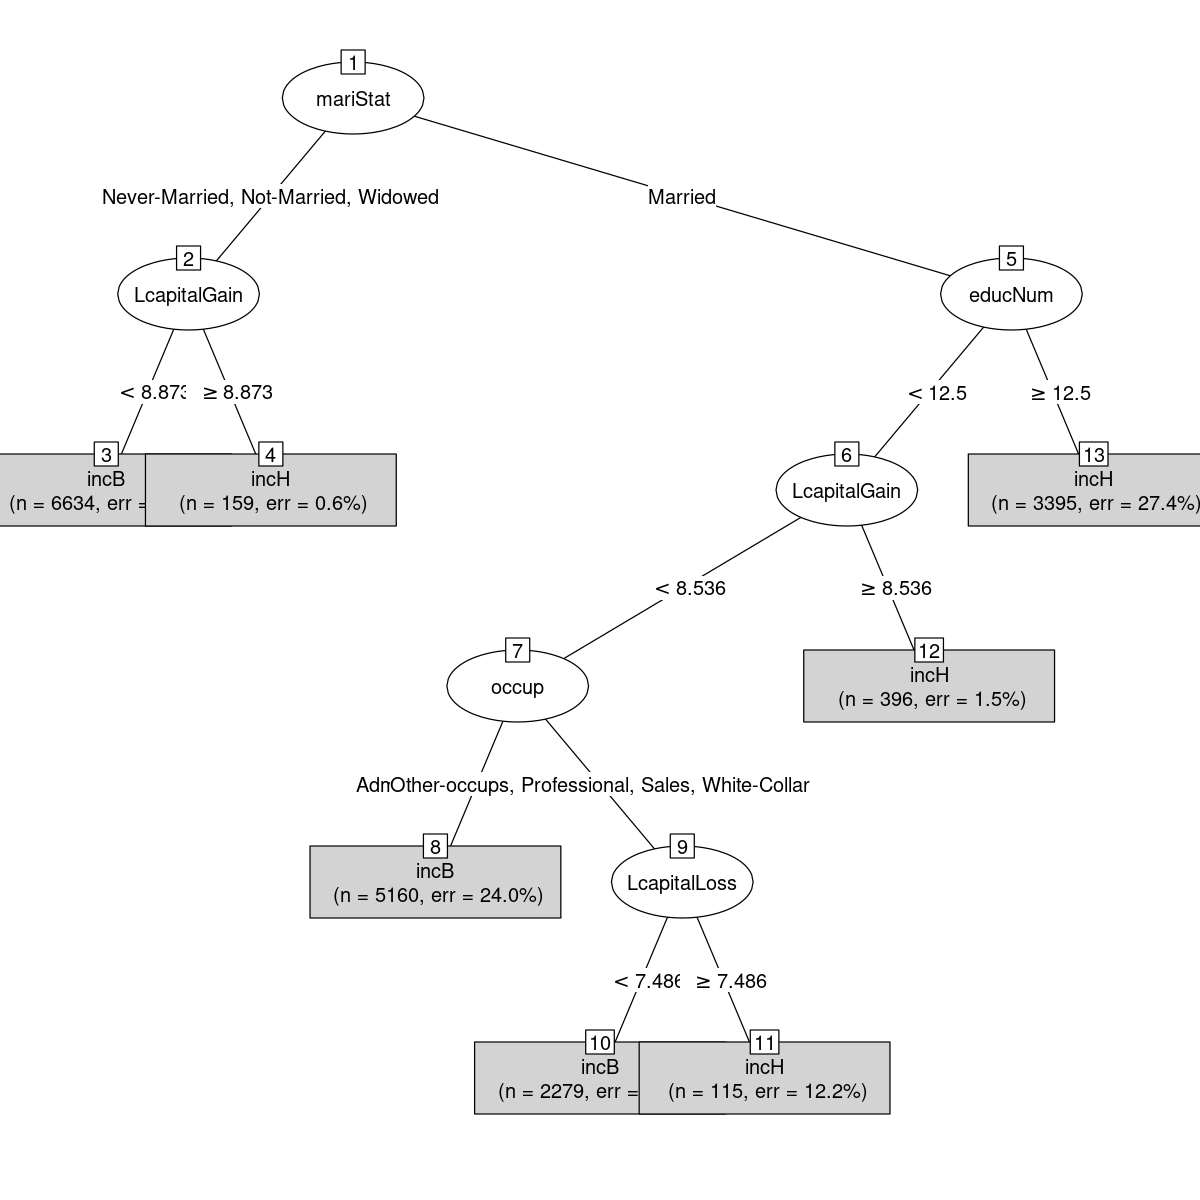

In [214]:
plot(as.party(tree.M), type="simple")

In [215]:
# prévision des modèles
yHatTree=predict(tree.init,newdata=daTest,type="class")
yHatFtree=predict(tree.F,newdata=daTestF,type="class")
yHatMtree=predict(tree.M,newdata=daTestM,type="class")
# compilation des prévisions
yHatFMtree=c(yHatFtree,yHatMtree)

In [216]:
# erreurs cumulées vs. erreur initiale de RF
table(yHatFMtree,daTestFM$income); table(yHatTree,daTest$income)

          
yHatFMtree incB incH
      incB 6309  987
      incH  437 1210

        
yHatTree incB incH
    incB 6366 1017
    incH  380 1180

In [217]:
tauxErr(table(yHatFMtree,daTestFM$income))
tauxErr(table(yHatTree,daTest$income))

[1] 15.92

[1] 15.62

In [218]:
# Biais cumulé vs. biais du modèle initial vs. biais de la base
round(dispImp(daTestFM[,"sex"],as.factor(yHatFMtree)),3)
round(dispImp(daTest[,"sex"],as.factor(yHatTree)),3)
round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)

[1] 0.399 0.452 0.506

[1] 0.270 0.315 0.359

[1] 0.322 0.362 0.402

###  *Random Forest*

In [246]:
library(randomForest)
set.seed(1)
# Modèle initial
RFinit=randomForest(income~.,data=datApp)
# Modèle en changeant les poids
RFinitW=randomForest(income~.,data=datApp, weigth=w)# weigth = w ne sert a rien
# estimation des deux modèles
RF.F=randomForest(income~.,data=datAppF[,-6])
RF.M=randomForest(income~.,data=datAppM[,-6])
# comparaison des paramètres

In [242]:
# prévision des modèles
yHatrf=predict(RFinit,newdata=daTest,type="response")
yHatrfW=predict(RFinitW,newdata=daTest,type="response")
yHatFrf=predict(RF.F,newdata=daTestF,type="response")
yHatMrf=predict(RF.M,newdata=daTestM,type="response")
# compilation des prévisions
yHatFMrf=c(yHatFrf,yHatMrf)

In [247]:
# erreurs cumulées vs. erreur initiale de RF
table(yHatFMrf,daTestFM$income); table(yHatrf,daTest$income)

        
yHatFMrf incB incH
    incB 6285  804
    incH  461 1393

      
yHatrf incB incH
  incB 6323  824
  incH  423 1373

**Q** Comparer les erreurs.

In [248]:
tauxErr(table(yHatFMrf,daTestFM$income))
tauxErr(table(yHatrf,daTest$income))
tauxErr(table(yHatrfW,daTest$income))

[1] 14.15

[1] 13.94

[1] 13.99

In [249]:
# Biais cumulé vs. biais du modèle initial vs. biais du modèle initial W vs. biais de la base
round(dispImp(daTestFM[,"sex"],as.factor(yHatFMrf)),3)
round(dispImp(daTest[,"sex"],as.factor(yHatrf)),3)
round(dispImp(daTest[,"sex"],as.factor(yHatrfW)),3)
round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)

[1] 0.316 0.359 0.403

[1] 0.305 0.349 0.392

[1] 0.300 0.343 0.386

[1] 0.322 0.362 0.402

**Q** Comparer les biais.
### Atténuation de la discrimination par *post-processing*
La procédure (*post-processing*) ci-dessous est la plus simple. Elle consiste à introduire une forme de discrimination positive en intervenant sur le seuil de décision pour les femmes tout en conservant celui par défaut de $0.5$ pour les hommes afin de ne pas plus les pénaliser. Elle est appliquée dans ce tutoriel aux seuls algorithmes arbre et forêt aléatoire. Une procédure graphique d'optimisation a été appliquée mais non reproduite afin de contrôler, sur l'échantillon de validation, l'effet de la correction à la fois sur le biais et sur l'erreur de prévision. Le seuil choisi ($0.3$) pour les femmes avec les forêts aléatoires pour décider d'un revenu élevé ($>50$k$) en découle. *Attention* ce seuil peut dépendre de l'échantillon validation et donc de l'initialisation du générateur de nombres aléatoires. Pour illustrer le choix du seuil le tracé des courbes ROC ci-dessous est instructif.

#### Tracé des courbes ROC

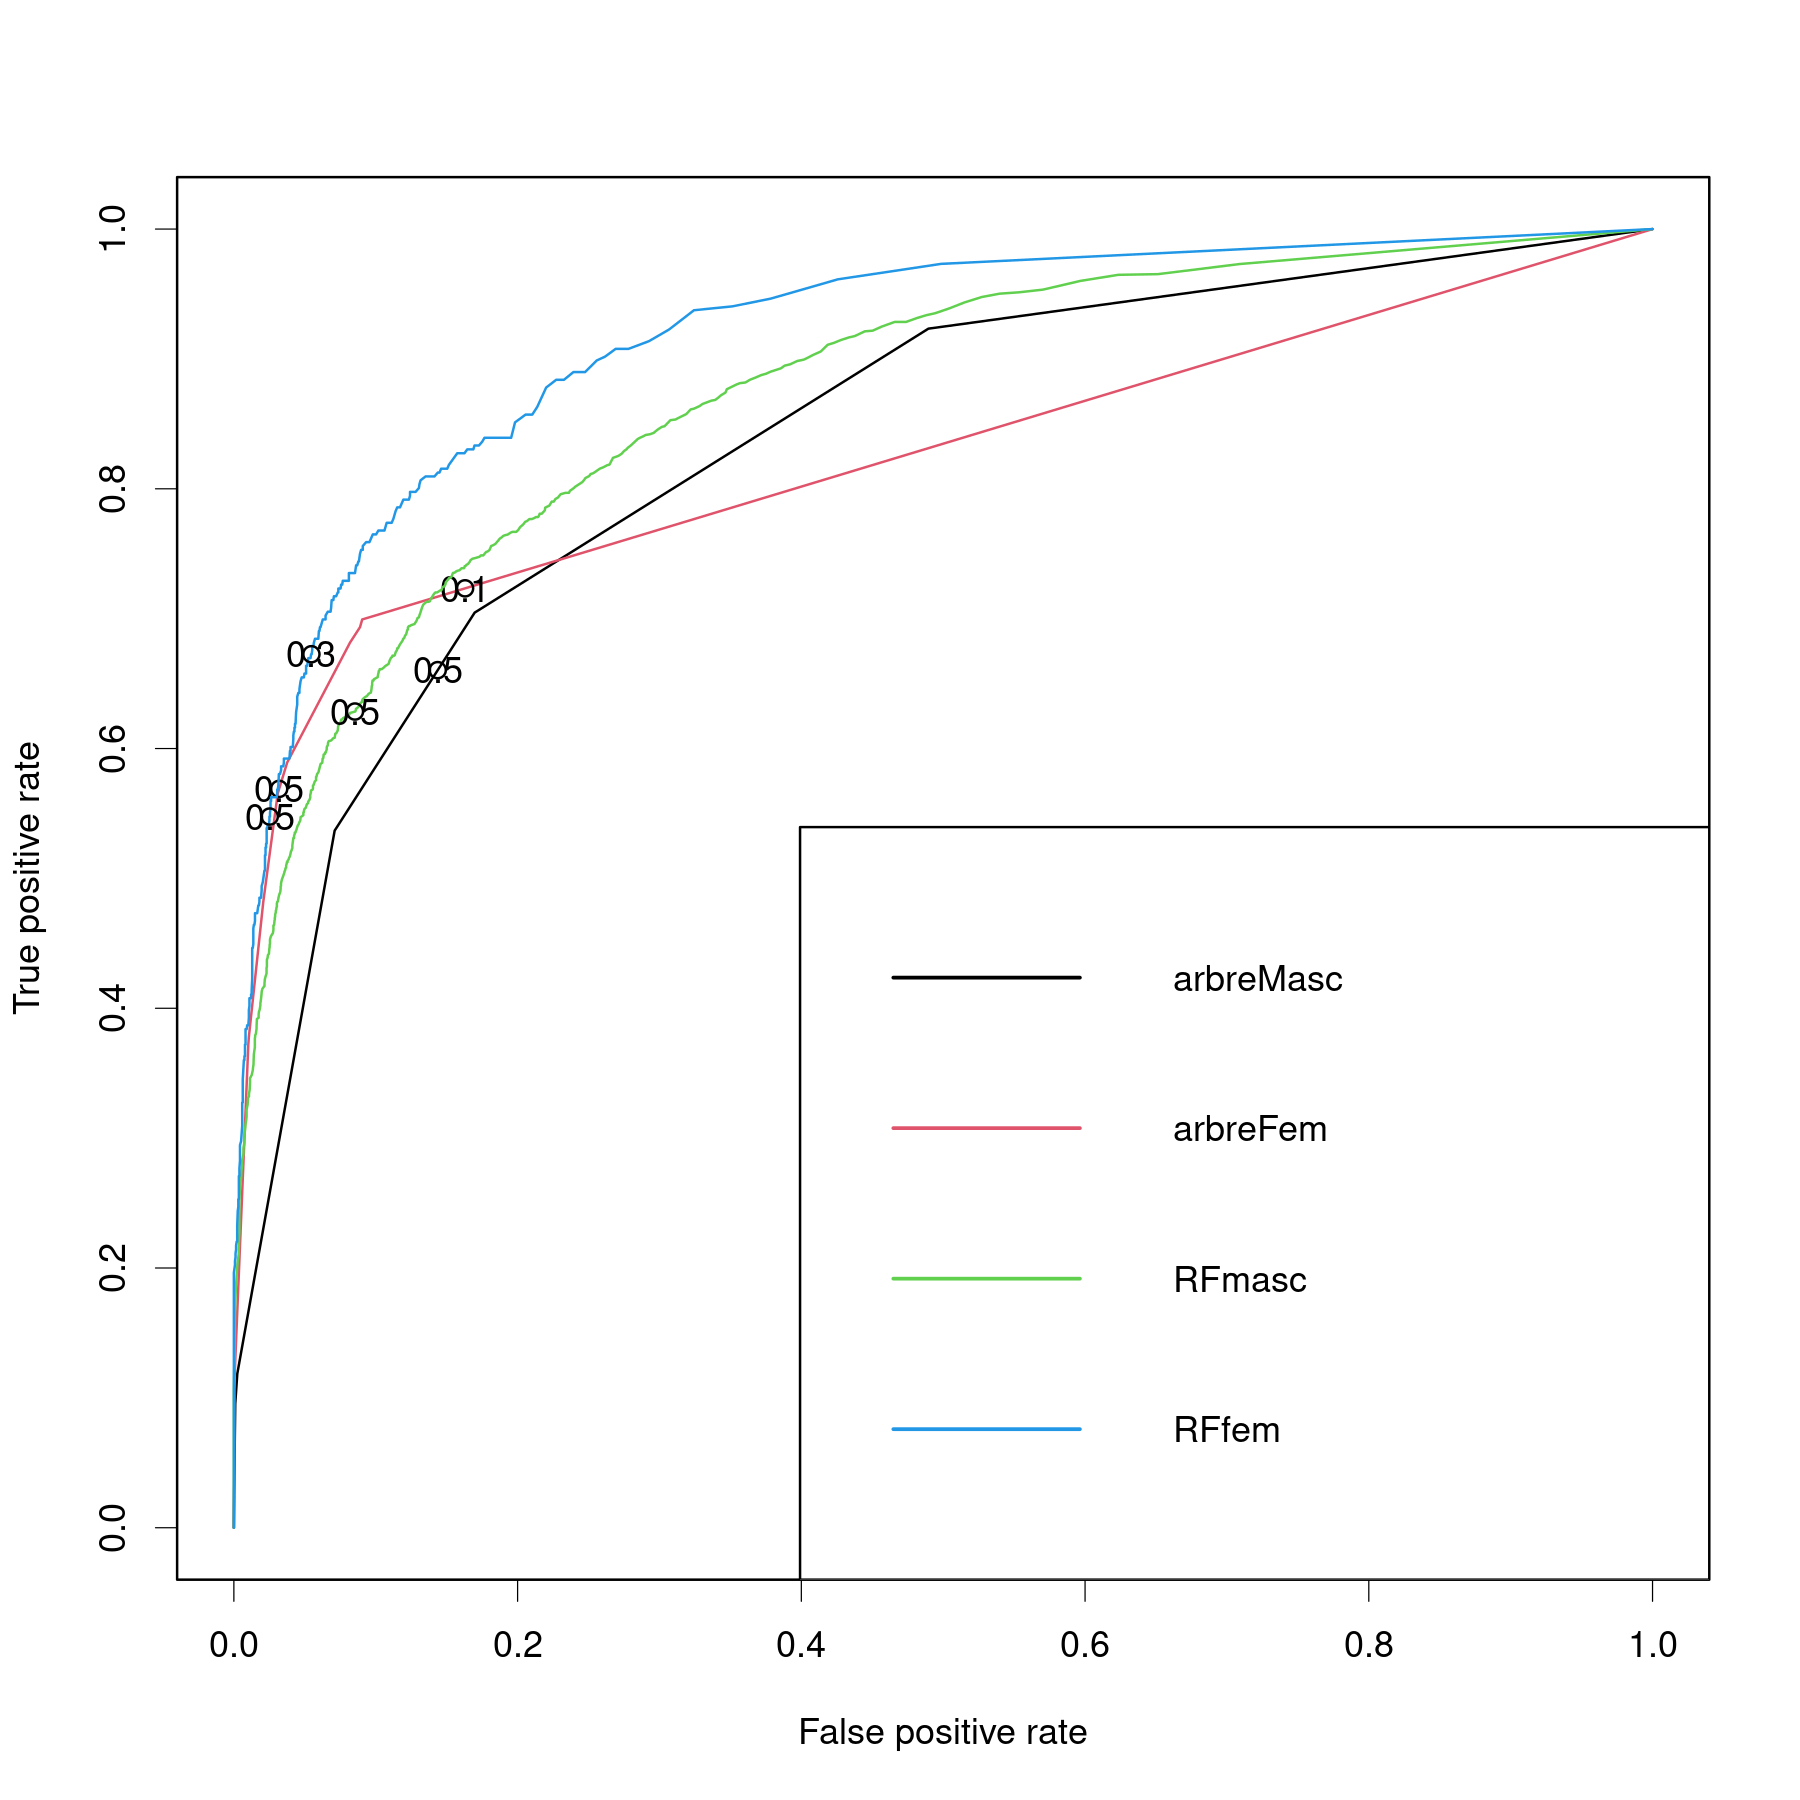

In [250]:
library(ROCR)
options(repr.plot.width=15, repr.plot.height=15)
ROCtreeM=predict(tree.M,newdata=datValM,type="prob")[,2]
predTreeM=prediction(ROCtreeM,datValM$income)
perfTreeM=performance(predTreeM,"tpr","fpr")
ROCtreeF=predict(tree.F,newdata=datValF,type="prob")[,2]
predTreeF=prediction(ROCtreeF,datValF$income)
perfTreeF=performance(predTreeF,"tpr","fpr")

ROCrfM=predict(RF.M,newdata=datValM,type="prob")[,2]
predRfM=prediction(ROCrfM,datValM$income)
perfRfM=performance(predRfM,"tpr","fpr")
ROCrfF=predict(RF.F,newdata=datValF,type="prob")[,2]
predRfF=prediction(ROCrfF,datValF$income)
perfRfF=performance(predRfF,"tpr","fpr")

par(cex=1.8,lwd=2)
plot(perfTreeM,col=1, print.cutoffs.at=c(0.5))
plot(perfTreeF,col=2, print.cutoffs.at=c(0.1, 0.5),add=TRUE)
plot(perfRfM,col=3, print.cutoffs.at=c(0.5),add=TRUE)
plot(perfRfF,col=4, print.cutoffs.at=c(0.3,0.5),add=TRUE)
legend("bottomright",legend=c("arbreMasc","arbreFem","RFmasc","RFfem"),col=c(1:4),cex=1,lwd=3)

**Objectif**: rapprocher les valeurs estimées sur l'échantillon de validation des taux de faux positifs tout en réduisant le biais systémique sans trop pénaliser les erreurs...

**Q** Arbres binaires: Commenter l'"optimalité" des choix des seuils $0.1$ pour les femmes et $0.5$ pour les hommes à la vue de ces courbes ROC.

**Q** Même chose pour les forêts aléatoires: $0.3$ et $0.5$.

#### Arbres binaires avec discriminaiton positive

In [251]:
# prévision des modèles en modifiant le seuil des femmes
yHatFtreeDP=predict(tree.F,newdata=daTestF,type="prob")[,2]>0.1
yHatMtreeDP=predict(tree.M,newdata=daTestM,type="prob")[,2]>0.5
# compilation des prévisions
yHatFMtreeDP=c(yHatFtreeDP,yHatMtreeDP)

In [252]:
table(yHatFMtreeDP,daTestFM$income)

            
yHatFMtreeDP incB incH
       FALSE 6142  947
       TRUE   604 1250

In [253]:
err=tauxErr(table(yHatFMtreeDP,daTestFM$income))
matRes[7,4]=(100-err)/100
err

[1] 17.34

In [228]:
ic=round(dispImp(daTestFM[,"sex"],as.factor(yHatFMtreeDP)),3)
matRes[7,1:3]=ic
ic

[1] 0.703 0.775 0.847

#### Forêts aléatoires avec discrimination positive

In [229]:
# prévision des modèles en modifiant le seuil des femmes
yHatFrfDP=predict(RF.F,newdata=daTestF,type="prob")[,2]>0.3
yHatMrfDP=predict(RF.M,newdata=daTestM,type="prob")[,2]>0.5
# compilation des prévisions
yHatFMrfDP=c(yHatFrfDP,yHatMrfDP)

In [230]:
table(yHatFMrfDP,daTestFM$income)

          
yHatFMrfDP incB incH
     FALSE 6213  769
     TRUE   533 1428

In [231]:
err=tauxErr(table(yHatFMrfDP,daTestFM$income))
matRes[8,4]=(100-err)/100
err

[1] 14.56

**Q** Que devient l'erreur de prévision?

In [232]:
ic=round(dispImp(daTestFM[,"sex"],as.factor(yHatFMrfDP)),3)
matRes[8,1:3]=ic
ic

[1] 0.452 0.504 0.556

**Q** Que devient le biais?
###  Synthèse graphique des résultats
Les résultats précédents: précisions des prévisions et intervalles de confiance sont collectés et affichés sur le même graphique.

In [254]:
matRes

,Lower,DI,Upper,Accuracy
,<dbl>,<dbl>,<dbl>,<dbl>
dataBaseBias,0.322,0.362,0.402,1.0000
linLogit,0.200,0.234,0.268,0.8370
tree,0.281,0.323,0.366,0.8585
linLogit_w_S,0.215,0.250,0.286,0.8376
testingLogit,0.864,0.919,0.973,0.8367
randomForest,0.297,0.340,0.383,0.8601
TreeDiscrPos,0.703,0.775,0.847,0.8266
RFdiscrPos,0.452,0.504,0.556,0.8544


**Attention**: décommenter la commande d'installation ci-dessous lors d'une exécution dans le nuage ou si tout simplement cette librairie n'est pas installée.

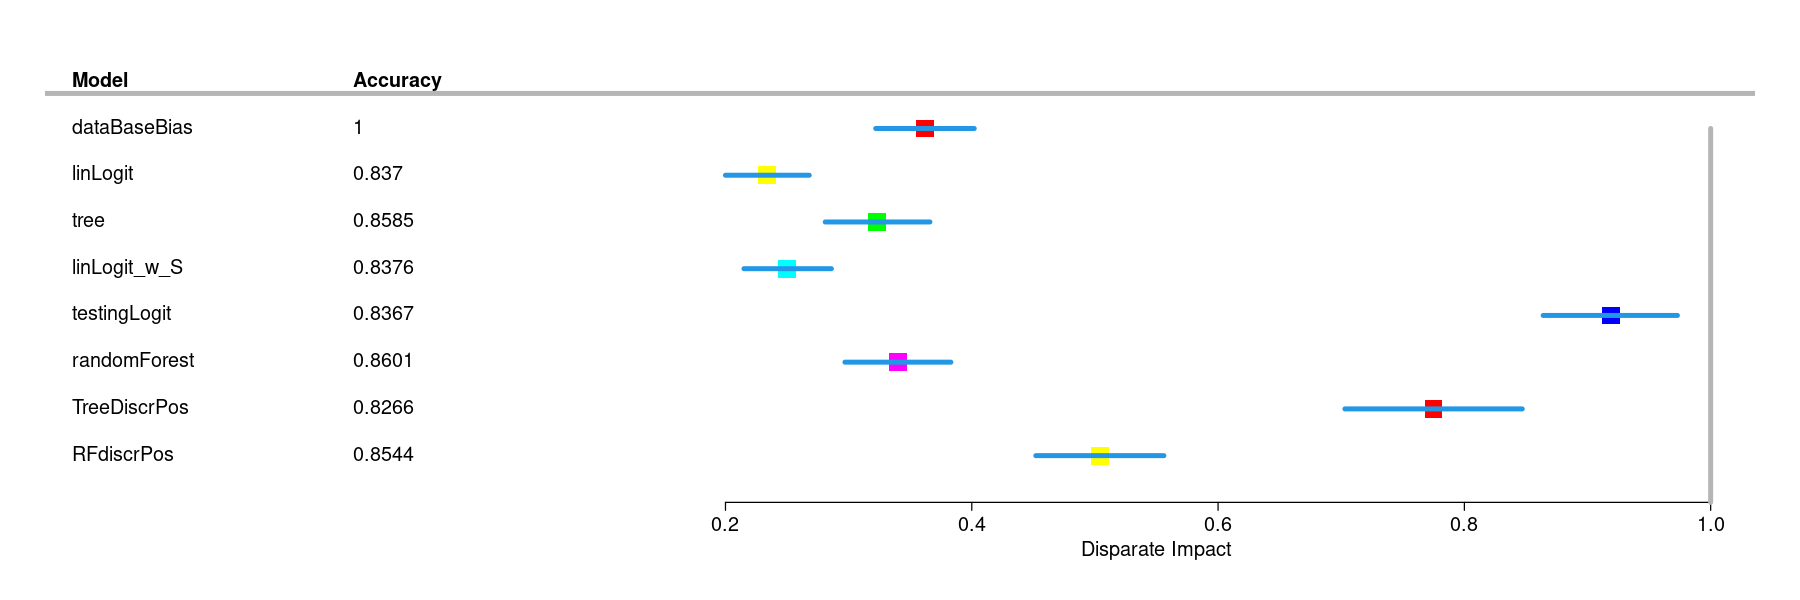

In [284]:
library(Publish)
options(repr.plot.width=15, repr.plot.height=5)
plotConfidence(x=matRes[,c("DI","Lower","Upper")],
               labels=data.frame("Model"=rownames(matRes),"Accuracy"=matRes[,"Accuracy"]),
               points.pch=15,points.cex=3,points.col=rainbow(6),
               values=FALSE,xlim=c(0.1,1),lwd=4,cex=1.5,
               xlab="Disparate Impact",xlab.cex=1,xratio=0.3,y.title.offset=1)

**Q** Comparer les différents bais en tenant compte de l'intersection des intervalles de confiance? Quels sont les algorithmes qui discriminent significativement? Est-il efficace de retirer la variable sensible du modèle? <br> - Non, c'est inutile (voir linLogit_w_S) <br>Que dire du *testing*? Comment intervient la discrimination positive ou le post-processing sur les décisions d'un arbre binaire ou  des forêts aléatoires. Est-il efficace? Quel moins mauvais compromis adopter entre précision, interprétabilité et biais?

**Attention**, l'atténuation du biais de société pour plus "d'équité" impacte également les autes biais, impact qu'il est important de considérer dans la section suivante.

##  Autres indicateurs de biais / discrimination
###  Biais sur les erreurs ou précisions de prévision conditionnelles
L'effet disproportionné est une première source de biais ou de discrimination parmi d'autres. Une deuxième, souvent évoquée, concerne les erreurs de prévision ou les précisions selon les modalités de la variable sensible; c'est  l'*overall error equality* ou de façon équivalente l'*overall accuracy equality*.

#### Régression logistique linéaire
*Overall error equality*

In [257]:
table(pred.log>0.5,daTest$income,daTest$sex)

, ,  = Female

       
        incB incH
  FALSE 2501  186
  TRUE    48  135

, ,  = Male

       
        incB incH
  FALSE 3696  723
  TRUE   501 1153


In [258]:
apply(table(pred.log>0.5,daTest$income,daTest$sex),3,tauxErr)

Female   Male 
  8.15  20.15


**Q** Quel genre semble défavorisé au regard de ce critère?

In [259]:
source('../Functions/overErrEqual.R')

In [260]:
round(overErrEqual(daTest$sex,daTest$income,as.factor(pred.log>0.5)),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
OEE,0.35,0.4,0.46


**Q** Même question.

#### Arbre binaire

In [261]:
table(yHatTree,daTest$income,daTest$sex)

, ,  = Female

        
yHatTree incB incH
    incB 2508  160
    incH   41  161

, ,  = Male

        
yHatTree incB incH
    incB 3858  857
    incH  339 1019


In [262]:
apply(table(yHatTree,daTest$income,daTest$sex),3,tauxErr)

Female   Male 
  7.00  19.69

In [285]:
round(overErrEqual(daTest$sex,daTest$income,yHatTree),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
OEE,0.3,0.36,0.41


#### Random forest

In [286]:
apply(table(yHatrf,daTest$income,daTest$sex),3,tauxErr)

Female   Male 
  6.59  17.42

In [287]:
round(overErrEqual(daTest$sex,daTest$income,yHatrf),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
OEE,0.32,0.38,0.43


**Q** Quel genre semble défavorisé au regard de ce critère?

#### Arbre binaire avec discrimination positive

In [288]:
tauxErr(table(yHatFtreeDP,daTestF$income)); tauxErr(table(yHatMtreeDP,daTestM$income))

[1] 12.4

[1] 19.68

In [289]:
round(overErrEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMtreeDP)),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
OEE,0.56,0.63,0.7


#### *Random forest* avec discrimination positive

In [290]:
tauxErr(table(yHatFrfDP,daTestF$income)); tauxErr(table(yHatMrfDP,daTestM$income))

[1] 8.01

[1] 17.65

In [291]:
round(overErrEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMrfDP)),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
OEE,0.39,0.45,0.52


**Q** L'évolution de ce critère est elle logique compte tenu de la correction adoptée sur la décision?

**Q** Cette correction est-elle socialement acceptable?

###  Asymétrie de la matrice de confusion: *equalitzed odds* 
Une autre source de discrimination est considérée. Elle a été mise en exergue par le site [Propublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) à propos du score de récidive COMPAS de la société *equivanf)) proposent une revue. Leurs définitions sont basées sur les différentes fréquences issues de la table de contingence et calculées par la fonction ci-dessous.t* utilisé dans certaines cours de justice américaines sous une forme de "justice prédictive". Le biais concerne une inversion de l'asymétrie de la matrice de confusion selon la variable sensible. De très nombreux critères ont été proposés pour évaluer cette asymétrie et dont [Verma et Rubin (2018](http://fairware.cs.umass.edu/papers/Verma.pd

In [307]:
contRatio <- function(T){ 
    # Ratios calculés à partir de la matrice de confusion
    TP=T[2,2] # true positive
    FP=T[2,1] # false positive
    FN=T[1,2] # false negative
    TN=T[1,1]  # true negative
    
    PPV=TP/(TP+FP) # P(Y=1|g(x)=1) positive predictive value
    FDR=FP/(TP+FP) # P(Y=0|g(x)=1) false discovery rate 
    FOR=FN/(TN+FN) # P(Y=1|g(x)=0) false omission rate
    NPV=TN/(TN+FN) # P(Y=0|g(x)=0) negative predictive value
    TPR=TP/(TP+FN) # P(g(x)=1|Y=1) true positive rate
    FPR=FP/(FP+TN) # P(g(x)=1|Y=0) false positive rate
    FNR=FN/(TP+FN) # P(g(x)=0|Y=1) false negative rate
    TNR=TN/(FP+TN) # P(g(x)=0|Y=0) true negative rate
    return(list("PPV"=PPV,"FDR"=FDR,"FOR"=FOR,"NPV"=NPV,"TPR"=TPR,"FPR"=FPR,"FNR"=FNR,"TNR"=TNR))
}

In [293]:
contRatio(table(pred.log>0.5,daTest$income))

$PPV
[1] 0.7011432

$FDR
[1] 0.2988568

$FOR
[1] 0.1279201

$NPV
[1] 0.8720799

$TPR
[1] 0.586254

$FPR
[1] 0.08138156

$FNR
[1] 0.413746

$TNR
[1] 0.9186184

Liste de critères d'équité pouvant être définis à partir des fréquences précédentes conditionnellement à la variable sensible. La combinatoire des possibles est importante mais peut être réduite en remarquant que *PPV*=1-*FDR*, *FOR*=1-*NPV*, *FPR*=1-*TNR*, *FNR*=1-*TPR*... Selon les auteurs, il y a équité de traitement si:
- *Predictive parity*: les deux groupes ont les mêmes *PPV*s et par conséquence les mêmes *FDR*s;
- *False positive error rate balance* ou *predictive equality*: mêmes *FPR*s et par conséquence les mêmes *TNR*s;
- *False negative error rate balance* ou *equal opportunity*: mêmes *FNR*s et par conséquence les mêmes *TPR*s;
- *Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds* combine les deux ci-dessus: mêmes *TPR*s **ET** mêmes *FPR*s;
- *Overall accuracy equality*: mêmes *TPR* **ET** mêmes *TNR*;
- *Conditionnal use accuracy equality*: mêmes *PPV*s **ET** mêmes *NPV*s;
- *Teatment equality*: les rapports *FN/FP* sont les mêmes pour les deux groupes.

Bien d'autres critères ont été proposés (cf. Verma et Rubin. 2018), il ne sont pas développés ici. Les calculs des *TPR* et *TNR* conditionnels sont privilégiés ci-dessous mais ce n'est qu'un choix parmi d'autres. Friedler et al. (2019) montrent que ceux-ci sont très corrélés justifiant qu'il est raisonnable de se limiter en première "lecture" aux seules comparaisons des *TPR* et *FPR*.

#### Régression logistique linéaire
La matrice de confusion est construite pour chaque genre pour comparer les différents indicateurs de loyauté.

In [294]:
fairness=data.frame("Female"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,1])),
                    "Male"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,2])))
fairness

,Female,Male
,<named list>,<named list>
PPV,0.7377049,0.6970979
FDR,0.2622951,0.3029021
FOR,0.06922218,0.1636117
NPV,0.9307778,0.8363883
TPR,0.4205607,0.6146055
FPR,0.01883091,0.119371
FNR,0.5794393,0.3853945
TNR,0.9811691,0.880629


Il serait fastidieux de construire toutes les comparaisons d'autant que beaucoup de ces indicateurs sont redondants. Seuls les  ***Equalized Odds*** sont estimés par des intervalles de  confiance à l'aide de la fonction `oddsEqual` qui  admet 4 paramètres:
- S: variable du groupe protégé
- Y: variable cible
- P: prévision $\hat{Y}$
- alpha=0.05, valeur par défaut.

Elle fournit l'estimation par intervalle de confiance des rapports des *FPR* et *TPR* conditionnels et permet donc de tester l'égalité ou non des cotes selon la variable sensible.

In [295]:
source('../Functions/oddsEqual.R')

In [296]:
round(oddsEqual(daTest$sex,daTest$income,as.factor(pred.log>0.5)),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
FPR,0.11,0.16,0.20
TPR,0.59,0.68,0.78


**Q** Quel genre semble favorisé au sens de chacun de ces indicateurs ? 

#### Arbre binaire
Affichage des matrices de confusion par genre:

In [297]:
table(yHatTree,daTest$income,daTest$sex)

, ,  = Female

        
yHatTree incB incH
    incB 2508  160
    incH   41  161

, ,  = Male

        
yHatTree incB incH
    incB 3858  857
    incH  339 1019


Calculs des différents critères

In [298]:
fairnessTree=data.frame("Female"=as.matrix(contRatio(table(yHatTree,daTest$income,daTest$sex)[,,1])),
                    "Male"=as.matrix(contRatio(table(yHatTree,daTest$income,daTest$sex)[,,2])))
fairnessTree

,Female,Male
,<named list>,<named list>
PPV,0.7970297,0.7503682
FDR,0.2029703,0.2496318
FOR,0.05997001,0.1817603
NPV,0.94003,0.8182397
TPR,0.5015576,0.543177
FPR,0.01608474,0.08077198
FNR,0.4984424,0.456823
TNR,0.9839153,0.919228


Comparer par exemple les taux de faux positifs et faux négatifs par genre ou encore les estimations des rapports ci-dessous:

In [299]:
round(oddsEqual(daTest$sex,daTest$income,yHatTree),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
FPR,0.14,0.20,0.26
TPR,0.82,0.92,1.03


**Q** Même question avec un arbre binaire. Que dire, si c'était l'évaluation d'un score de crédit, des risques engagés par la banque selon le genre et donc de la rupture d'équité qui en découle?

#### *Random forest* 

In [300]:
fairnessRF=data.frame("Female"=as.matrix(contRatio(table(yHatrf,daTest$income,daTest$sex)[,,1])),
                    "Male"=as.matrix(contRatio(table(yHatrf,daTest$income,daTest$sex)[,,2])))
fairnessRF

,Female,Male
,<named list>,<named list>
PPV,0.7598425,0.7652399
FDR,0.2401575,0.2347601
FOR,0.04892966,0.1536085
NPV,0.9510703,0.8463915
TPR,0.6012461,0.6289979
FPR,0.02393095,0.08625208
FNR,0.3987539,0.3710021
TNR,0.976069,0.9137479


In [301]:
round(oddsEqual(daTest$sex,daTest$income,yHatrf),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
FPR,0.20,0.28,0.35
TPR,0.86,0.96,1.05


**Q** Même question avec une forêt aléatoire.

#### Arbre binaire avec discrimination positive

In [302]:
fairnessRFDP=data.frame("Female"=as.matrix(contRatio(table(yHatFtreeDP,daTestF$income))),
                    "Male"=as.matrix(contRatio(table(yHatMtreeDP,daTestM$income))))
fairnessRFDP

,Female,Male
,<named list>,<named list>
PPV,0.4647887,0.7509211
FDR,0.5352113,0.2490789
FOR,0.03792668,0.1817218
NPV,0.9620733,0.8182782
TPR,0.7196262,0.543177
FPR,0.1043546,0.08053371
FNR,0.2803738,0.456823
TNR,0.8956454,0.9194663


In [303]:
round(oddsEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMtreeDP)),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
FPR,1.10,1.30,1.49
TPR,1.22,1.32,1.43


#### *Random forest* avec discrimination positive

In [304]:
fairnessRFDP=data.frame("Female"=as.matrix(contRatio(table(yHatFrfDP,daTestF$income))),
                    "Male"=as.matrix(contRatio(table(yHatMrfDP,daTestM$income))))
fairnessRFDP

,Female,Male
,<named list>,<named list>
PPV,0.6206897,0.7537879
FDR,0.3793103,0.2462121
FOR,0.03489771,0.1519269
NPV,0.9651023,0.8480731
TPR,0.728972,0.6364606
FPR,0.05610043,0.09292352
FNR,0.271028,0.3635394
TNR,0.9438996,0.9070765


In [305]:
round(oddsEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMrfDP)),2)

,inf,est_value,sup
,<dbl>,<dbl>,<dbl>
FPR,0.49,0.60,0.72
TPR,1.06,1.15,1.23


**Q** La correction va-t-elle dans le sens attendu? 

**Q** En conclusion, le traitement par post-processing du seuil va-t-il, pour cet exemple, dans le bon sens pour tous les critères de biais?

**Exercice** Commenter les "recommandations" de [Goglin (2021)](https://theconversation.com/discrimination-et-ia-comment-limiter-les-risques-en-matiere-de-credit-bancaire-167008).

## Conclusion

Conclure sur 
- le choix entre un modèle linéaire, arbre, agrégation d'arbres pour la qualité de prévision *vs.* l'interprétabilité.
- l'intervention de la variable sensible dans un modèle et donc sur l'effet d'une interdiction de prendre en compte une variable sensible comme l'origine ethnique,
- l'efficacité du testing, 
- en considérant les trois types de biais considérés, lequel mettrait en évidence une rupture d'équité selon le genre vis-à-vis des risques encourus par une banque?
- les impacts du post processing rudimentaire mis en oeuvre sur la précision, les autres biais.

Finalement, quel choix d'algorithme opérer et comment le justifier d'un point de vue économique pour une banque mais aussi d'image sociale d'équité de la procédure.

**Remarques** .
- Il n'est sans doute pas nécessaire d'estimer deux modèles selon le genre. Le seul post-processing des seuils de décision devrait suffire.
- Aux USA le calcul de l'*adverse* ou *disparate impact* est pris en compte dans les embauches par obligation du code du travail en tenant à jour des "statistiques ethniques". En France seules des opérations de testing sont déployées.
- Aux USA, l'utilisation d'un algorithme non linéaire sans contrôle est risquée car un biais trop important ($DI<0.8$) sans explication, donc justification possible, est condamnable. C'est la raison pour laquelle certaines entreprises américaines de la *hiring tech* proposent des atténuations du biais afin d'économiser des poursuites judiciaires (Raghavan et al. 2019).
- Un `data scientist` dispose actuellement d'une grande latitude pour faire ce qu'il veut, sans contrôle: du comportement déloyal, condamnable, à la discrimination positive pour introduire plus d'équité dans la société!
- Nous pouvons espérer, qu'après la mise en place du RGPD, l'adoption de l'*AI Act* impacte ces pratiques.
- Un gros travail en vue pour un *data scientist* responsable d'un traitement qui devra tenir à jour une documentation complète et détaillée de toutes ces procédures, du recueil des données au suivi d'un système d'intelligence artificielle en exploitation. 

**Il est vivement recommandé d'anticiper sur cette réglementation à venir afin de justifier les choix opérés, à savoir le moins mauvais compromis faisant intervenir, confidentialité des données, précision des prévisions, interprétabilité du modèle et biais ou risques de discrimination.**



## Références
Barocas S., Selbst A. (2016). [Big Data's Disparate Impact](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2477899), *California Law Review*, 671.

Besse P. (2020). [Détecter, évaluer les risques des impacts discriminatoires des algorithmes d'IA](https://hal.archives-ouvertes.fr/hal-02616963), Contribution au séminaire Défenseur des Droits et CNIL, 28 mai 2020, article soumis.

Besse P. del Barrio E. Gordaliza P. Loubes J.-M., Risser L. (2021). [A survey of bias in Machine Learning through the prism of Statistical Parity for the Adult Data Set](https://doi.org/10.1080/00031305.2021.1952897), The American Statistician , DOI: 10.1080/00031305.2021.1952897 [Open access version](https://arxiv.org/pdf/2003.14263.pdf).

Efron B. (1987). [Better Bootstrap Confidence Intervals](https://www.jstor.org/stable/2289144?seq=1), *Journal of the American Statistical Association*, Vol. 82, No. 397 (Mar., 1987), pp. 171-185. 

Friedler S., Scheidegger C., Venkatasubramanian S., Choudhary S., Hamilton E., Roth D. (2019). [A comparative study of fairness-enhancing interventions in machine learning](https://dl.acm.org/doi/10.1145/3287560.3287589), *Proceedings of the Conference on Fairness, Accountability, and Transparency*.

Morris S., Lobsenz R. (2000), [Signifiance Tests and Confidence Intervals for the Adverse Impact Ratio](https://doi.org/10.1111/j.1744-6570.2000.tb00195.x) *Personnel Psychology*, 53: 89-111.

Riach, P., Rich J. (2002). [Field Experiments of Discrimination In The Market Place]( https://doi.org/10.1111/1468-0297.00080), *The Economic Journal*, Vol. 112, 480-518.

Raghavan M., Barocas S., Kleinberg J., Levy K. (2019) [Mitigating bias in Algorithmic Hiring : Evaluating Claims and Practices](https://arxiv.org/abs/1906.09208), arXiv:1906.09208.

Verma S., Rubin J. (2018). [Fairness Definitions Explained](http://fairware.cs.umass.edu/papers/Verma.pdf),  *ACM/IEEE International Workshop on Software Fairness*.

Zliobaitė I. (2015). [A survey on measuring indirect discrimination in machine learning](https://arxiv.org/pdf/1511.00148.pdf), arXiv preprint.
